In [1]:
import numpy as np
from scipy.stats import t
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import io
import requests
import seaborn as sns
import math
from IPython.display import display, Image
%matplotlib inline

In [2]:
data=pd.read_csv("taxi.csv") 
data.head(5)

offer_gk  weekday_key  hour_key  driver_gk  order_gk  driver_latitude  \
0   1105373            5        20       6080    174182        55.818842   
1    759733            5        14       6080    358774        55.805342   
2    416977            6        14       6080    866260        55.813978   
3    889660            2         6       6080    163522        55.745922   
4   1120055            4        16       6080    506710        55.803578   

   driver_longitude  origin_order_latitude  origin_order_longitude  \
0         37.334562              55.814567               37.355010   
1         37.515023              55.819329               37.466398   
2         37.347688              55.814827               37.354074   
3         37.421748              55.743469               37.431130   
4         37.521602              55.812559               37.527407   

   distance_km  duration_min offer_class_group ride_type_desc  driver_response  
0       -1.000        -1.000           Economy        private                0  
1       18.802        25.217          Standard        private                1  
2        6.747         9.800           Economy        private                0  
3       -1.000        -1.000           Economy        private                1  
4       12.383        19.250           Economy        private                1

In [3]:
data.describe()

offer_gk    weekday_key       hour_key      driver_gk  \
count  1.000000e+05  100000.000000  100000.000000  100000.000000   
mean   5.662189e+05       3.159860      13.827790    3446.376360   
std    3.259360e+05       2.054222       7.306496    2038.738677   
min    4.000000e+00       0.000000       0.000000      14.000000   
25%    2.855552e+05       1.000000       8.000000    1421.000000   
50%    5.656715e+05       3.000000      16.000000    3506.500000   
75%    8.487198e+05       5.000000      20.000000    5242.000000   
max    1.130355e+06       6.000000      23.000000    6806.000000   

           order_gk  driver_latitude  driver_longitude  origin_order_latitude  \
count  100000.00000    100000.000000     100000.000000          100000.000000   
mean   460867.01291        55.700824         37.492292              55.772440   
std    266064.98953         2.135903          1.454640               0.665985   
min        18.00000        -1.000000         -1.000000              -1.000000   
25%    229178.50000        55.708651         37.413497              55.708032   
50%    462420.00000        55.772904         37.533664              55.772561   
75%    690894.00000        55.960667         37.624113              55.962000   
max    920344.00000        56.174097         38.280547              56.311121   

       origin_order_longitude    distance_km   duration_min  driver_response  
count           100000.000000  100000.000000  100000.000000    100000.000000  
mean                37.541637      18.393518      23.134841         0.492480  
std                  0.467758      41.129296      33.890105         0.499946  
min                 -1.000000      -1.000000      -1.000000         0.000000  
25%                 37.407117      -1.000000      -1.000000         0.000000  
50%                 37.532537      10.411500      19.700000         0.000000  
75%                 37.624358      30.665250      37.867000         1.000000  
max                 38.243608    5234.283000    3958.283000         1.000000

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
dtypes: float64(6), int64(6), object(2)
memory usage: 10.7+ MB


Что мы видим после беглого осмотра? Самые печальная ситуация по признаку 'distance_km'. Второй квартиль равен -1.  
Очевидно это фейковые данные. Есть мысль, что мы сможеим это исправить, т.к. у нас есть координаты водителя и координаты заказа:  
'driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude'.  
Возможно координаты заказа - это не координаты заказчика , а координаты конечной точки и может быть мы сможем вычислить недостающие данные по  
'distance_km'.

In [183]:
def distance_earth (lut_start ,long_start ,lut_end, long_end):
    """Функция расчета расстояния между точками по широте и долготе точек"""
    R = 6400
    a = math.pi / 180
    sin = math.sin(lut_start * a) * math.sin(lut_end * a)
    cos = math.cos(lut_start * a) * math.cos(lut_end * a)
    cos_dif = math.cos(long_end * a - long_start * a)
    try:
        distance = round( R * math.acos(sin + cos * cos_dif), 3)
    except: 
        distance = 0.0
        print (lut_start ,long_start ,lut_end, long_end)
        print (sin + cos * cos_dif)
    return distance

Проверка работоспособности функции

In [6]:
print ('Расстояние от Ижевска до Москвы:', distance_earth (57, 53, 55.75, 37.5))

Расстояние от Ижевска до Москвы: 966.711


In [7]:
print ('Расстояние от Ижевска до Перми:', distance_earth (57, 53, 58, 56))

Расстояние от Ижевска до Перми: 211.857


Все работает идеально, посмотрим можно ли расчитать недостающие значения 'distance_km' 

In [184]:
lut_start = data.loc[1, 'driver_latitude']
long_start = data.loc[1, 'driver_longitude']
lut_end = data.loc[1, 'origin_order_latitude']
long_end = data.loc[1, 'origin_order_longitude']
distance = data.loc[1, 'distance_km']

print ('Проба пера', distance_earth (lut_start ,long_start ,lut_end, long_end), distance)

Проба пера 3.429 18.802


In [9]:
lut_start = data.loc[2, 'driver_latitude']
long_start = data.loc[2, 'driver_longitude']
lut_end = data.loc[2, 'origin_order_latitude']
long_end = data.loc[2, 'origin_order_longitude']
distance = data.loc[2, 'distance_km']

print ('Проба пера', distance_earth (lut_start ,long_start ,lut_end, long_end), distance)

Проба пера 0.412 6.747000000000001


Восстановить отсутствующие значения по признаку 'distance_km' через другие признаки невозможно  
Тем не менее, раз уж есть возможность, посчитаем все расстояния. Судя по всему это расстояния между таксистом и заказчиком в момент заказа

In [185]:
for index in data.index:
    lut_start = data.loc[index, 'driver_latitude']
    long_start = data.loc[index, 'driver_longitude']
    lut_end = data.loc[index, 'origin_order_latitude']
    long_end = data.loc[index, 'origin_order_longitude']
    data.loc[index, 'distance_order'] = distance_earth (lut_start ,long_start ,lut_end, long_end)

55.966694 37.415753 55.966694 37.415754
1.0000000000000002
55.966694 37.415753 55.966694 37.415754
1.0000000000000002


Столкнулся с тем, что значения из-за ошибки числа с плавающей точкой выходили за пределы применимости формулы. Обошел эту ошибку

In [186]:
data.head()

offer_gk  weekday_key  hour_key  driver_gk  order_gk  driver_latitude  \
1    759733            5        14       6080    358774        55.805342   
2    416977            6        14       6080    866260        55.813978   
4   1120055            4        16       6080    506710        55.803578   
5   1058203            6        15       6080    360328        55.818963   
7    128861            5        20       6080    254374        55.839318   

   driver_longitude  origin_order_latitude  origin_order_longitude  \
1         37.515023              55.819329               37.466398   
2         37.347688              55.814827               37.354074   
4         37.521602              55.812559               37.527407   
5         37.361033              55.814827               37.354074   
7         37.248862              55.839134               37.304101   

   distance_km  duration_min offer_class_group ride_type_desc  \
1       18.802        25.217          Standard        private   
2        6.747         9.800           Economy        private   
4       12.383        19.250           Economy        private   
5        6.747         9.800           Economy        private   
7        1.517         3.933           Economy        private   

   driver_response  distance_order    driver      time  
1                1           3.429  0.579137  0.613758  
2                0           0.412  0.579137  0.613758  
4                1           1.067  0.579137  0.613758  
5                0           0.636  0.579137  0.613758  
7                0           3.465  0.579137  0.413628

Ранее видели еще плохие данные как раз среди координат. Посмотрим сколько их

In [12]:
data[data['driver_latitude'] == -1].groupby('driver_latitude').sum()

offer_gk  weekday_key  hour_key  driver_gk  order_gk  \
driver_latitude                                                         
-1.0             83318353          422      2022     612541  60738982   

                 driver_longitude  origin_order_latitude  \
driver_latitude                                            
-1.0                       -140.0            7772.302181   

                 origin_order_longitude  distance_km  duration_min  \
driver_latitude                                                      
-1.0                        5289.852993      825.172       867.601   

                 driver_response  distance_order  
driver_latitude                                   
-1.0                         140      1012269.72

In [13]:
data[data['driver_latitude'] == -1].groupby('driver_latitude').count()

offer_gk  weekday_key  hour_key  driver_gk  order_gk  \
driver_latitude                                                         
-1.0                  140          140       140        140       140   

                 driver_longitude  origin_order_latitude  \
driver_latitude                                            
-1.0                          140                    140   

                 origin_order_longitude  distance_km  duration_min  \
driver_latitude                                                      
-1.0                                140          140           140   

                 offer_class_group  ride_type_desc  driver_response  \
driver_latitude                                                       
-1.0                           140             140              140   

                 distance_order  
driver_latitude                  
-1.0                        140

In [14]:
data[data['origin_order_latitude'] == -1].groupby('origin_order_latitude').sum()

offer_gk  weekday_key  hour_key  driver_gk  order_gk  \
origin_order_latitude                                                         
-1.0                    9433112           42       209      38911   4901793   

                       driver_latitude  driver_longitude  \
origin_order_latitude                                      
-1.0                        724.430403        488.359242   

                       origin_order_longitude  distance_km  duration_min  \
origin_order_latitude                                                      
-1.0                                    -13.0      142.716       224.534   

                       driver_response  distance_order  
origin_order_latitude                                   
-1.0                                 8       94091.794

In [15]:
data[data['origin_order_latitude'] == -1].groupby('origin_order_latitude').count()

offer_gk  weekday_key  hour_key  driver_gk  order_gk  \
origin_order_latitude                                                         
-1.0                         13           13        13         13        13   

                       driver_latitude  driver_longitude  \
origin_order_latitude                                      
-1.0                                13                13   

                       origin_order_longitude  distance_km  duration_min  \
origin_order_latitude                                                      
-1.0                                       13           13            13   

                       offer_class_group  ride_type_desc  driver_response  \
origin_order_latitude                                                       
-1.0                                  13              13               13   

                       distance_order  
origin_order_latitude                  
-1.0                               13

In [16]:
data[(data['origin_order_latitude'] == -1) & (data['driver_latitude'] == -1)]

Empty DataFrame
Columns: [offer_gk, weekday_key, hour_key, driver_gk, order_gk, driver_latitude, driver_longitude, origin_order_latitude, origin_order_longitude, distance_km, duration_min, offer_class_group, ride_type_desc, driver_response, distance_order]
Index: []

In [17]:
data[data['driver_longitude'] == -1].groupby('driver_longitude').sum()

offer_gk  weekday_key  hour_key  driver_gk  order_gk  \
driver_longitude                                                         
-1.0              83318353          422      2022     612541  60738982   

                  driver_latitude  origin_order_latitude  \
driver_longitude                                           
-1.0                       -140.0            7772.302181   

                  origin_order_longitude  distance_km  duration_min  \
driver_longitude                                                      
-1.0                         5289.852993      825.172       867.601   

                  driver_response  distance_order  
driver_longitude                                   
-1.0                          140      1012269.72

In [18]:
data[data['origin_order_latitude'] == -1].groupby('origin_order_latitude').sum()

offer_gk  weekday_key  hour_key  driver_gk  order_gk  \
origin_order_latitude                                                         
-1.0                    9433112           42       209      38911   4901793   

                       driver_latitude  driver_longitude  \
origin_order_latitude                                      
-1.0                        724.430403        488.359242   

                       origin_order_longitude  distance_km  duration_min  \
origin_order_latitude                                                      
-1.0                                    -13.0      142.716       224.534   

                       driver_response  distance_order  
origin_order_latitude                                   
-1.0                                 8       94091.794

Пока просто будем учитывать наличие этих фейковых данных. Посмотрим как дюрация связана с длиной поездки

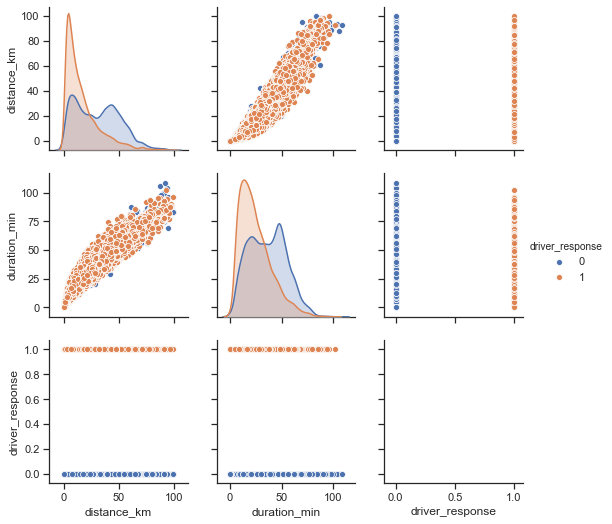

In [20]:
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(data = data[(data['distance_km'] != -1) & (data['distance_km'] < 100)][['distance_km', 'duration_min', 'driver_response']], hue='driver_response')
plt.show()

Понятно, что дюрация - это время поездки

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
offer_gk                  100000 non-null int64
weekday_key               100000 non-null int64
hour_key                  100000 non-null int64
driver_gk                 100000 non-null int64
order_gk                  100000 non-null int64
driver_latitude           100000 non-null float64
driver_longitude          100000 non-null float64
origin_order_latitude     100000 non-null float64
origin_order_longitude    100000 non-null float64
distance_km               100000 non-null float64
duration_min              100000 non-null float64
offer_class_group         100000 non-null object
ride_type_desc            100000 non-null object
driver_response           100000 non-null int64
distance_order            100000 non-null float64
dtypes: float64(7), int64(6), object(2)
memory usage: 11.4+ MB


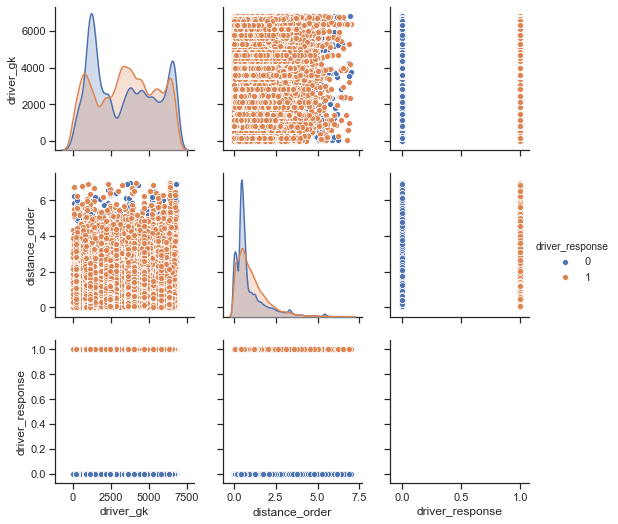

In [45]:
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(data = data[(data['driver_latitude'] != -1) & (data['origin_order_latitude'] != -1) & (data['distance_order'] < 7)][['driver_gk', 'distance_order', 'driver_response']], hue='driver_response')
plt.show()

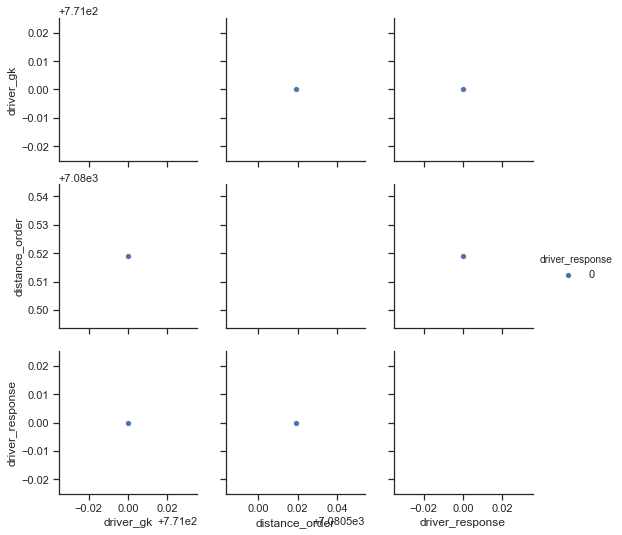

In [47]:
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(data = data[(data['driver_latitude'] != -1) & (data['origin_order_latitude'] != -1) & (data['distance_order'] > 1000)][['driver_gk', 'distance_order', 'driver_response']], hue='driver_response')
plt.show()

Нашли еще один фейк. Здесь уже конечные графики, я весь поиск выкладывать не стал

In [48]:
data[(data['driver_latitude'] != -1) & (data['origin_order_latitude'] != -1) & (data['distance_order'] > 1000)]

offer_gk  weekday_key  hour_key  driver_gk  order_gk  driver_latitude  \
55260    271817            0        14        771    306124              0.0   

       driver_longitude  origin_order_latitude  origin_order_longitude  \
55260               0.0              55.410307               37.902451   

       distance_km  duration_min offer_class_group ride_type_desc  \
55260       43.726         55.45           Economy        private   

       driver_response  distance_order  
55260                0        7080.519

In [49]:
data[data['driver_latitude'] == -1].describe()

offer_gk  weekday_key    hour_key    driver_gk       order_gk  \
count  1.400000e+02   140.000000  140.000000   140.000000     140.000000   
mean   5.951311e+05     3.014286   14.442857  4375.292857  433849.871429   
std    3.259230e+05     1.877491    6.034996  1943.232883  279849.421221   
min    8.529000e+03     0.000000    0.000000    14.000000    6975.000000   
25%    3.256392e+05     1.000000   11.000000  3399.000000  202384.250000   
50%    6.229185e+05     3.000000   14.500000  4567.000000  385691.000000   
75%    8.746392e+05     5.000000   19.000000  6166.000000  676863.000000   
max    1.122859e+06     6.000000   23.000000  6792.000000  917874.000000   

       driver_latitude  driver_longitude  origin_order_latitude  \
count            140.0             140.0             140.000000   
mean              -1.0              -1.0              55.516444   
std                0.0               0.0               0.175498   
min               -1.0              -1.0              55.336188   
25%               -1.0              -1.0              55.415361   
50%               -1.0              -1.0              55.415361   
75%               -1.0              -1.0              55.607256   
max               -1.0              -1.0              56.311121   

       origin_order_longitude  distance_km  duration_min  driver_response  \
count              140.000000   140.000000    140.000000            140.0   
mean                37.784664     5.894086      6.197150              1.0   
std                  0.200718    20.373721     20.301839              0.0   
min                 37.168915    -1.000000     -1.000000              1.0   
25%                 37.661407    -1.000000     -1.000000              1.0   
50%                 37.898917    -1.000000     -1.000000              1.0   
75%                 37.898917    -1.000000     -1.000000              1.0   
max                 38.132620   105.126000     92.550000              1.0   

       distance_order  
count      140.000000  
mean      7230.498000  
std         11.264351  
min       7208.817000  
25%       7227.329000  
50%       7227.329000  
75%       7227.329000  
max       7309.524000

In [50]:
data[data['driver_latitude'] == 0].describe()

offer_gk  weekday_key  hour_key  driver_gk  order_gk  driver_latitude  \
count       1.0          1.0       1.0        1.0       1.0              1.0   
mean   271817.0          0.0      14.0      771.0  306124.0              0.0   
std         NaN          NaN       NaN        NaN       NaN              NaN   
min    271817.0          0.0      14.0      771.0  306124.0              0.0   
25%    271817.0          0.0      14.0      771.0  306124.0              0.0   
50%    271817.0          0.0      14.0      771.0  306124.0              0.0   
75%    271817.0          0.0      14.0      771.0  306124.0              0.0   
max    271817.0          0.0      14.0      771.0  306124.0              0.0   

       driver_longitude  origin_order_latitude  origin_order_longitude  \
count               1.0               1.000000                1.000000   
mean                0.0              55.410307               37.902451   
std                 NaN                    NaN                     NaN   
min                 0.0              55.410307               37.902451   
25%                 0.0              55.410307               37.902451   
50%                 0.0              55.410307               37.902451   
75%                 0.0              55.410307               37.902451   
max                 0.0              55.410307               37.902451   

       distance_km  duration_min  driver_response  distance_order  
count        1.000          1.00              1.0           1.000  
mean        43.726         55.45              0.0        7080.519  
std            NaN           NaN              NaN             NaN  
min         43.726         55.45              0.0        7080.519  
25%         43.726         55.45              0.0        7080.519  
50%         43.726         55.45              0.0        7080.519  
75%         43.726         55.45              0.0        7080.519  
max         43.726         55.45              0.0        7080.519

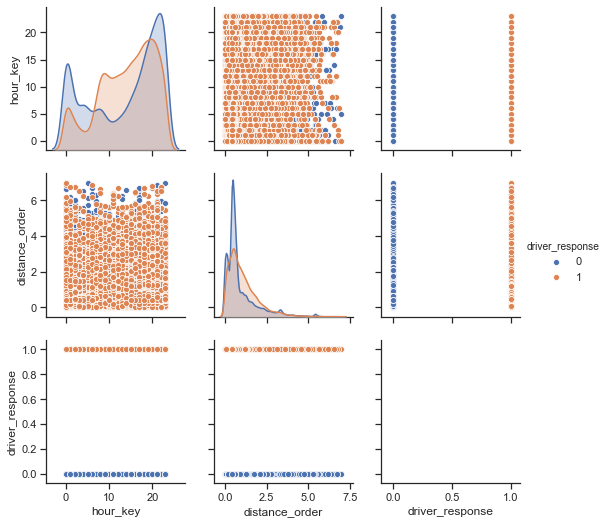

In [188]:
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(data = data[(data['driver_latitude'] != -1) & (data['origin_order_latitude'] != -1) & (data['distance_order'] < 7)][['hour_key', 'distance_order', 'driver_response']], hue='driver_response')
plt.show()

Была мысль, что есть связь со временем заказа и маршрутом

Разбираемся с фейковыми данными

In [75]:
data.drop(data[data['driver_latitude'] == -1].index, inplace=True)
data[data['driver_latitude'] == -1]

Empty DataFrame
Columns: [offer_gk, weekday_key, hour_key, driver_gk, order_gk, driver_latitude, driver_longitude, origin_order_latitude, origin_order_longitude, distance_km, duration_min, offer_class_group, ride_type_desc, driver_response, distance_order, driver]
Index: []

In [76]:
data.drop(data[data['origin_order_latitude'] == -1].index, inplace=True)
data[data['origin_order_latitude'] == -1]

Empty DataFrame
Columns: [offer_gk, weekday_key, hour_key, driver_gk, order_gk, driver_latitude, driver_longitude, origin_order_latitude, origin_order_longitude, distance_km, duration_min, offer_class_group, ride_type_desc, driver_response, distance_order, driver]
Index: []

In [77]:
data.drop(data[data['origin_order_latitude'] == 0].index, inplace=True)
data[data['origin_order_latitude'] == 0]

Empty DataFrame
Columns: [offer_gk, weekday_key, hour_key, driver_gk, order_gk, driver_latitude, driver_longitude, origin_order_latitude, origin_order_longitude, distance_km, duration_min, offer_class_group, ride_type_desc, driver_response, distance_order, driver]
Index: []

In [78]:
data.drop(data[data['driver_latitude'] == 0].index, inplace=True)
data[data['driver_latitude'] == 0]

Empty DataFrame
Columns: [offer_gk, weekday_key, hour_key, driver_gk, order_gk, driver_latitude, driver_longitude, origin_order_latitude, origin_order_longitude, distance_km, duration_min, offer_class_group, ride_type_desc, driver_response, distance_order, driver]
Index: []

In [79]:
data.drop(data[data['distance_km'] == -1].index, inplace=True)
data[data['distance_km'] == -1]

Empty DataFrame
Columns: [offer_gk, weekday_key, hour_key, driver_gk, order_gk, driver_latitude, driver_longitude, origin_order_latitude, origin_order_longitude, distance_km, duration_min, offer_class_group, ride_type_desc, driver_response, distance_order, driver]
Index: []

Удалили все, в том числе и данные по длине маршрута. Дело в том, что ранее мы могли видеть, что решение водителя зависит от длины маршрута.  
Поэтому попытаемся сохранить, что есть и использовать

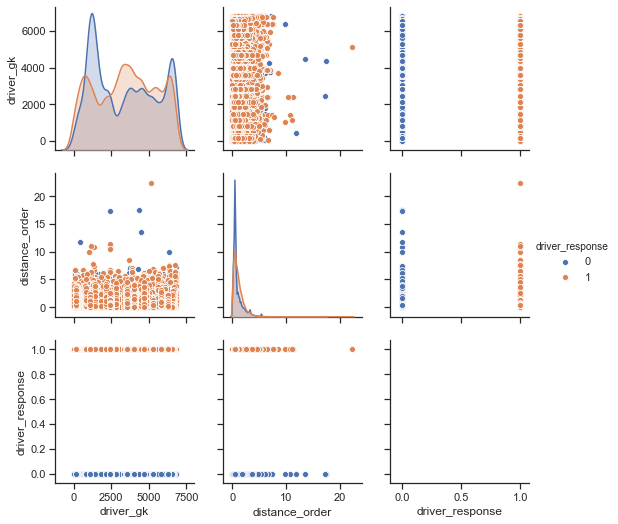

In [57]:
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(data = data[['driver_gk', 'distance_order', 'driver_response']], hue='driver_response')
plt.show()

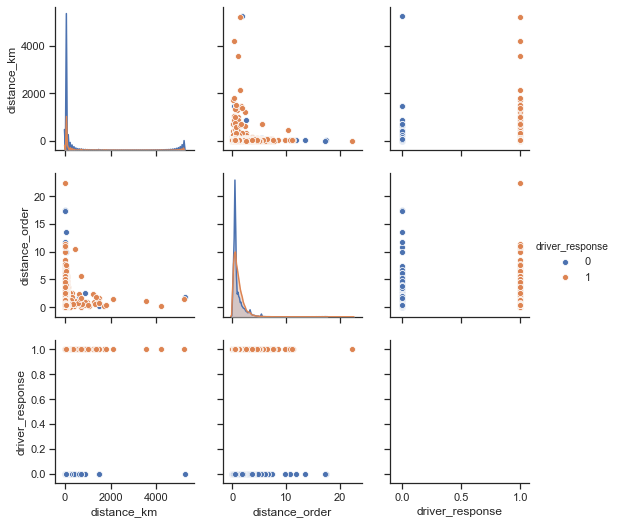

In [58]:
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(data = data[['distance_km', 'distance_order', 'driver_response']], hue='driver_response')
plt.show()

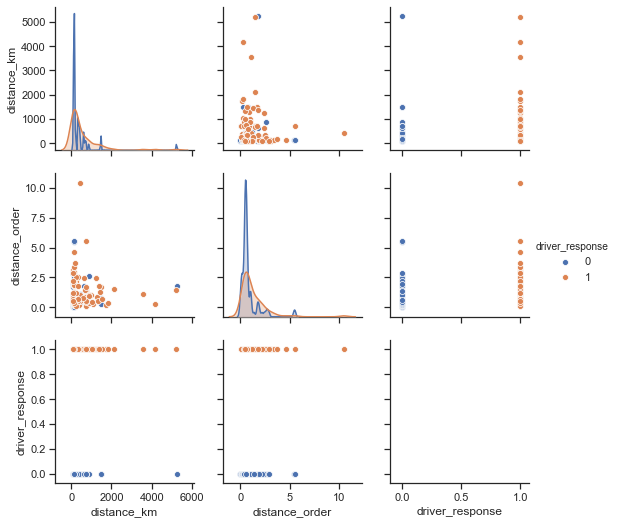

In [59]:
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(data = data[data['distance_km'] > 100][['distance_km', 'distance_order', 'driver_response']], hue='driver_response')
plt.show()

In [60]:
data[data['distance_km'] > 100].groupby('driver_response').count()

offer_gk  weekday_key  hour_key  driver_gk  order_gk  \
driver_response                                                         
0                      85           85        85         85        85   
1                      89           89        89         89        89   

                 driver_latitude  driver_longitude  origin_order_latitude  \
driver_response                                                             
0                             85                85                     85   
1                             89                89                     89   

                 origin_order_longitude  distance_km  duration_min  \
driver_response                                                      
0                                    85           85            85   
1                                    89           89            89   

                 offer_class_group  ride_type_desc  distance_order  
driver_response                                                     
0                               85              85              85  
1                               89              89              89

In [61]:
data[data['distance_km'] < 100].groupby('driver_response').count()

offer_gk  weekday_key  hour_key  driver_gk  order_gk  \
driver_response                                                         
0                   38889        38889     38889      38889     38889   
1                   34700        34700     34700      34700     34700   

                 driver_latitude  driver_longitude  origin_order_latitude  \
driver_response                                                             
0                          38889             38889                  38889   
1                          34700             34700                  34700   

                 origin_order_longitude  distance_km  duration_min  \
driver_response                                                      
0                                 38889        38889         38889   
1                                 34700        34700         34700   

                 offer_class_group  ride_type_desc  distance_order  
driver_response                                                     
0                            38889           38889           38889  
1                            34700           34700           34700

In [62]:
data.groupby('offer_class_group').sum()

offer_gk  weekday_key  hour_key  driver_gk     order_gk  \
offer_class_group                                                               
Delivery             504157406         2944     13109    3128075    409769643   
Economy            23130864091       128997    560381  146450766  18829789020   
Kids                 318946327         2002      8241    1960574    264835276   
Premium              577469925         3281     13961    4349726    469970385   
Standard           16882959598        93110    414793   97390377  13835902024   
VIP                   62184681          419      1504     306255     49175585   
VIP+                   7591884           43       165      34574      5648404   
XL                   249847645         1581      5832    1705854    209433765   

                   driver_latitude  driver_longitude  origin_order_latitude  \
offer_class_group                                                             
Delivery              4.951129e+04      3.338041e+04           4.951137e+04   
Economy               2.276516e+06      1.532682e+06           2.276493e+06   
Kids                  3.171742e+04      2.138238e+04           3.171783e+04   
Premium               5.632539e+04      3.792963e+04           5.632528e+04   
Standard              1.668886e+06      1.122844e+06           1.668862e+06   
VIP                   6.021380e+03      4.059125e+03           6.021627e+03   
VIP+                  6.132983e+02      4.134030e+02           6.133681e+02   
XL                    2.496847e+04      1.685133e+04           2.496675e+04   

                   origin_order_longitude  distance_km  duration_min  \
offer_class_group                                                      
Delivery                     3.337949e+04    14470.595     23501.789   
Economy                      1.532657e+06   967293.462   1239013.219   
Kids                         2.138254e+04     9250.034     13703.394   
Premium                      3.792730e+04    16324.237     25075.337   
Standard                     1.122847e+06   837419.863   1014898.611   
VIP                          4.059412e+03     8469.518      7647.331   
VIP+                         4.134808e+02       93.413       194.567   
XL                           1.685124e+04    11102.050     14385.306   

                   driver_response  distance_order  
offer_class_group                                   
Delivery                       592        1767.187  
Economy                      17851       39477.337  
Kids                           477        1212.501  
Premium                        778        1604.273  
Standard                     14680       27561.221  
VIP                             83         207.630  
VIP+                            10          16.641  
XL                             318        1313.589

In [63]:
data.groupby('offer_class_group').count()

offer_gk  weekday_key  hour_key  driver_gk  order_gk  \
offer_class_group                                                         
Delivery                888          888       888        888       888   
Economy               40816        40816     40816      40816     40816   
Kids                    569          569       569        569       569   
Premium                1010         1010      1010       1010      1010   
Standard              29913        29913     29913      29913     29913   
VIP                     108          108       108        108       108   
VIP+                     11           11        11         11        11   
XL                      448          448       448        448       448   

                   driver_latitude  driver_longitude  origin_order_latitude  \
offer_class_group                                                             
Delivery                       888               888                    888   
Economy                      40816             40816                  40816   
Kids                           569               569                    569   
Premium                       1010              1010                   1010   
Standard                     29913             29913                  29913   
VIP                            108               108                    108   
VIP+                            11                11                     11   
XL                             448               448                    448   

                   origin_order_longitude  distance_km  duration_min  \
offer_class_group                                                      
Delivery                              888          888           888   
Economy                             40816        40816         40816   
Kids                                  569          569           569   
Premium                              1010         1010          1010   
Standard                            29913        29913         29913   
VIP                                   108          108           108   
VIP+                                   11           11            11   
XL                                    448          448           448   

                   ride_type_desc  driver_response  distance_order  
offer_class_group                                                   
Delivery                      888              888             888  
Economy                     40816            40816           40816  
Kids                          569              569             569  
Premium                      1010             1010            1010  
Standard                    29913            29913           29913  
VIP                           108              108             108  
VIP+                           11               11              11  
XL                            448              448             448

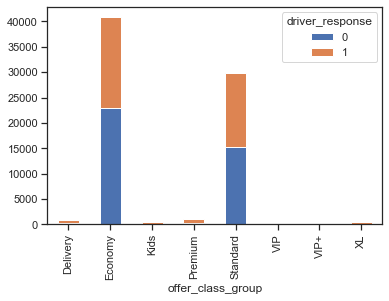

In [64]:
data.pivot_table('offer_gk', 'offer_class_group', 'driver_response', 'count').plot(kind='bar', stacked=True)

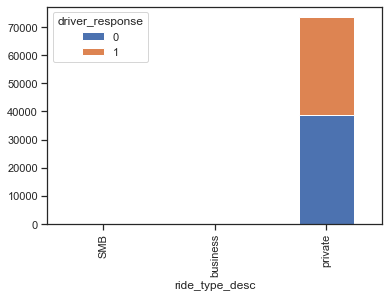

In [65]:
data.pivot_table('offer_gk', 'ride_type_desc', 'driver_response', 'count').plot(kind='bar', stacked=True)

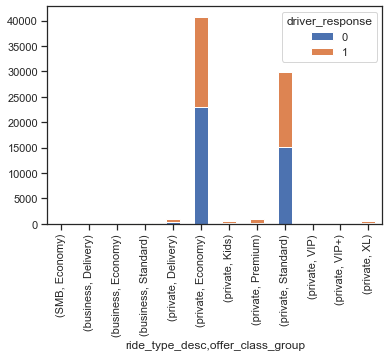

In [66]:
data.pivot_table('offer_gk', ('ride_type_desc','offer_class_group'), 'driver_response', 'count').plot(kind='bar', stacked=True)

In [67]:
data[['ride_type_desc','driver_response']].groupby('ride_type_desc').describe()

driver_response                                             
                         count      mean       std  min  25%  50%  75%  max
ride_type_desc                                                             
SMB                       19.0  0.526316  0.512989  0.0  0.0  1.0  1.0  1.0
business                 153.0  0.647059  0.479454  0.0  0.0  1.0  1.0  1.0
private                73591.0  0.471253  0.499176  0.0  0.0  0.0  1.0  1.0

In [68]:
data[['offer_class_group','driver_response']].groupby('offer_class_group').describe()

driver_response                                             
                            count      mean       std  min  25%  50%  75%  max
offer_class_group                                                             
Delivery                    888.0  0.666667  0.471670  0.0  0.0  1.0  1.0  1.0
Economy                   40816.0  0.437353  0.496066  0.0  0.0  0.0  1.0  1.0
Kids                        569.0  0.838313  0.368488  0.0  1.0  1.0  1.0  1.0
Premium                    1010.0  0.770297  0.420850  0.0  1.0  1.0  1.0  1.0
Standard                  29913.0  0.490757  0.499923  0.0  0.0  0.0  1.0  1.0
VIP                         108.0  0.768519  0.423746  0.0  1.0  1.0  1.0  1.0
VIP+                         11.0  0.909091  0.301511  0.0  1.0  1.0  1.0  1.0
XL                          448.0  0.709821  0.454352  0.0  0.0  1.0  1.0  1.0

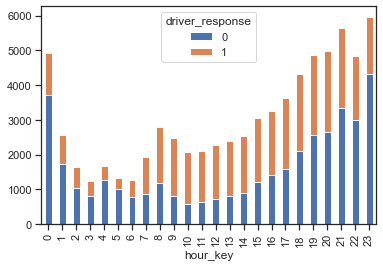

In [69]:
data.pivot_table('offer_gk', 'hour_key', 'driver_response', 'count').plot(kind='bar', stacked=True)

In [102]:
data[['hour_key','driver_response']].groupby('hour_key').describe()

driver_response                                              
                   count      mean       std  min  25%  50%   75%  max
hour_key                                                              
0                 4919.0  0.246188  0.430833  0.0  0.0  0.0  0.00  1.0
1                 2573.0  0.323747  0.467996  0.0  0.0  0.0  1.00  1.0
2                 1650.0  0.375758  0.484465  0.0  0.0  0.0  1.00  1.0
3                 1234.0  0.356564  0.479179  0.0  0.0  0.0  1.00  1.0
4                 1666.0  0.234694  0.423935  0.0  0.0  0.0  0.00  1.0
5                 1332.0  0.250000  0.433175  0.0  0.0  0.0  0.25  1.0
6                 1270.0  0.387402  0.487349  0.0  0.0  0.0  1.00  1.0
7                 1923.0  0.544462  0.498149  0.0  0.0  1.0  1.00  1.0
8                 2795.0  0.580322  0.493595  0.0  0.0  1.0  1.00  1.0
9                 2490.0  0.672289  0.469473  0.0  0.0  1.0  1.00  1.0
10                2062.0  0.716780  0.450672  0.0  0.0  1.0  1.00  1.0
11                2096.0  0.700859  0.457991  0.0  0.0  1.0  1.00  1.0
12                2270.0  0.689868  0.462649  0.0  0.0  1.0  1.00  1.0
13                2390.0  0.660669  0.473581  0.0  0.0  1.0  1.00  1.0
14                2530.0  0.646245  0.478229  0.0  0.0  1.0  1.00  1.0
15                3049.0  0.604133  0.489116  0.0  0.0  1.0  1.00  1.0
16                3268.0  0.570379  0.495098  0.0  0.0  1.0  1.00  1.0
17                3617.0  0.559580  0.496506  0.0  0.0  1.0  1.00  1.0
18                4312.0  0.512987  0.499889  0.0  0.0  1.0  1.00  1.0
19                4878.0  0.475605  0.499456  0.0  0.0  0.0  1.00  1.0
20                4983.0  0.467188  0.498972  0.0  0.0  0.0  1.00  1.0
21                5639.0  0.406810  0.491282  0.0  0.0  0.0  1.00  1.0
22                4850.0  0.382474  0.486042  0.0  0.0  0.0  1.00  1.0
23                5967.0  0.278197  0.448148  0.0  0.0  0.0  1.00  1.0

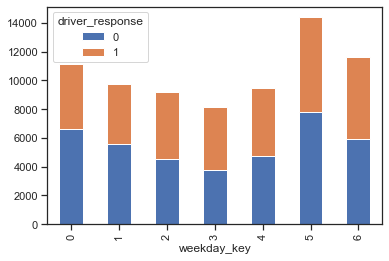

In [70]:
data.pivot_table('offer_gk', 'weekday_key', 'driver_response', 'count').plot(kind='bar', stacked=True)

In [103]:
data[['weekday_key','driver_response']].groupby('weekday_key').describe()

driver_response                                             
                      count      mean       std  min  25%  50%  75%  max
weekday_key                                                             
0                   11138.0  0.404022  0.490724  0.0  0.0  0.0  1.0  1.0
1                    9733.0  0.426487  0.494592  0.0  0.0  0.0  1.0  1.0
2                    9219.0  0.512854  0.499862  0.0  0.0  1.0  1.0  1.0
3                    8177.0  0.538951  0.498511  0.0  0.0  1.0  1.0  1.0
4                    9447.0  0.499100  0.500026  0.0  0.0  0.0  1.0  1.0
5                   14407.0  0.456722  0.498141  0.0  0.0  0.0  1.0  1.0
6                   11642.0  0.490294  0.499927  0.0  0.0  0.0  1.0  1.0

Еще поковырялись с графиками. Есть хорошая зависимость процента отказов от времени суток.

Теперь возьмемся вплотную за широту и долготу. Есть надежда, что они коррелируют с решением водителя и тогда возможно полученный нами признак 'distance_order'  
(расстояние от таксиста до заказчика) нам еще пригодится

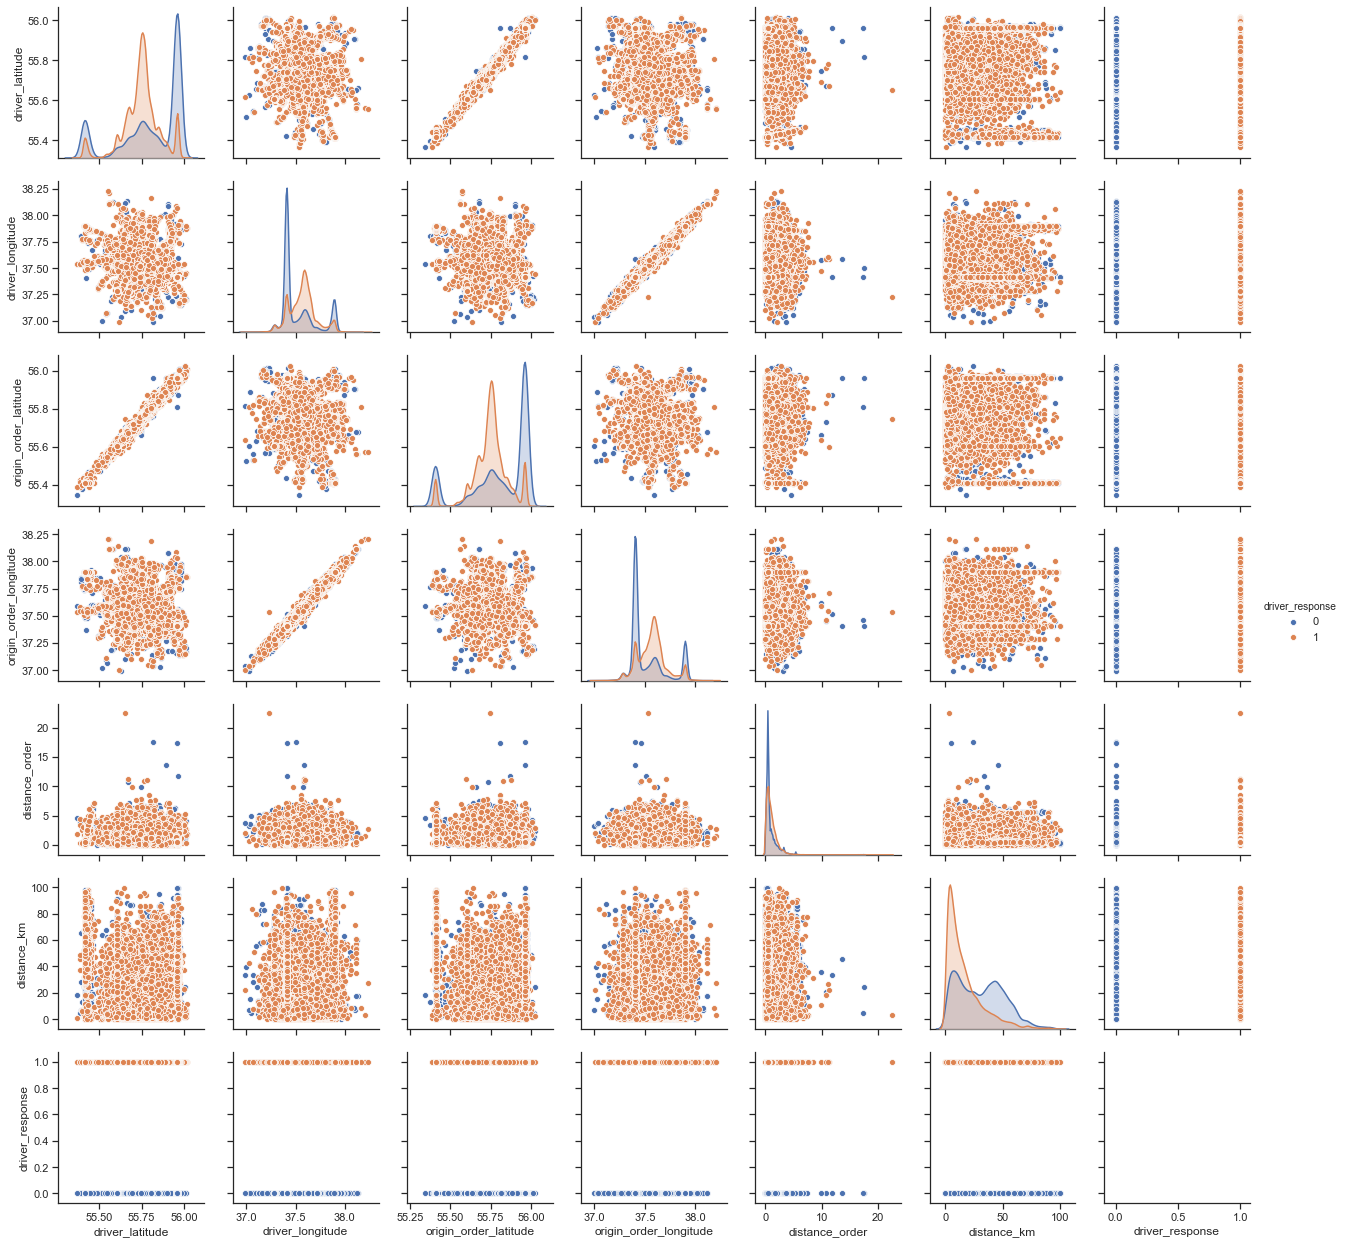

In [71]:
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(data = data[data['distance_km'] < 100][['driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude', 'distance_order', 'distance_km', 'driver_response']], hue='driver_response')
plt.show()

Карта города какого-то очевидно получена на некоторых графиках

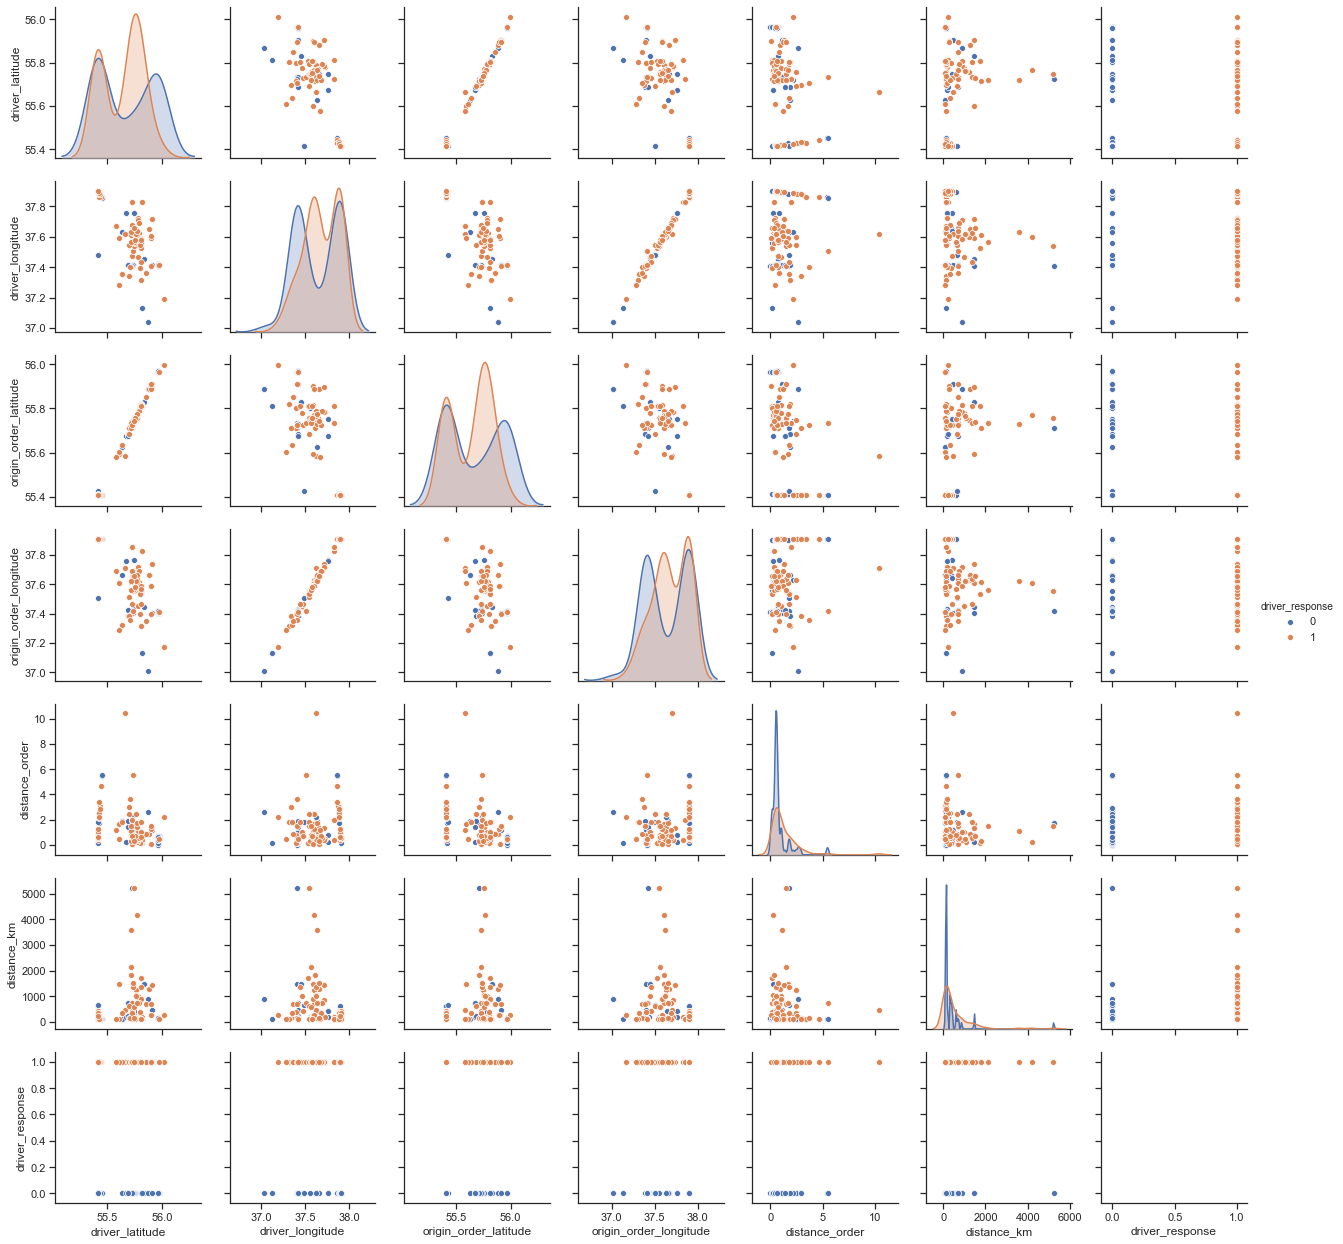

In [72]:
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(data = data[data['distance_km'] > 100][['driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude', 'distance_order', 'distance_km', 'driver_response']], hue='driver_response')
plt.show()

**Возникла мысль карту увеличить, чтобы более детально изучить взаимосвязи** 

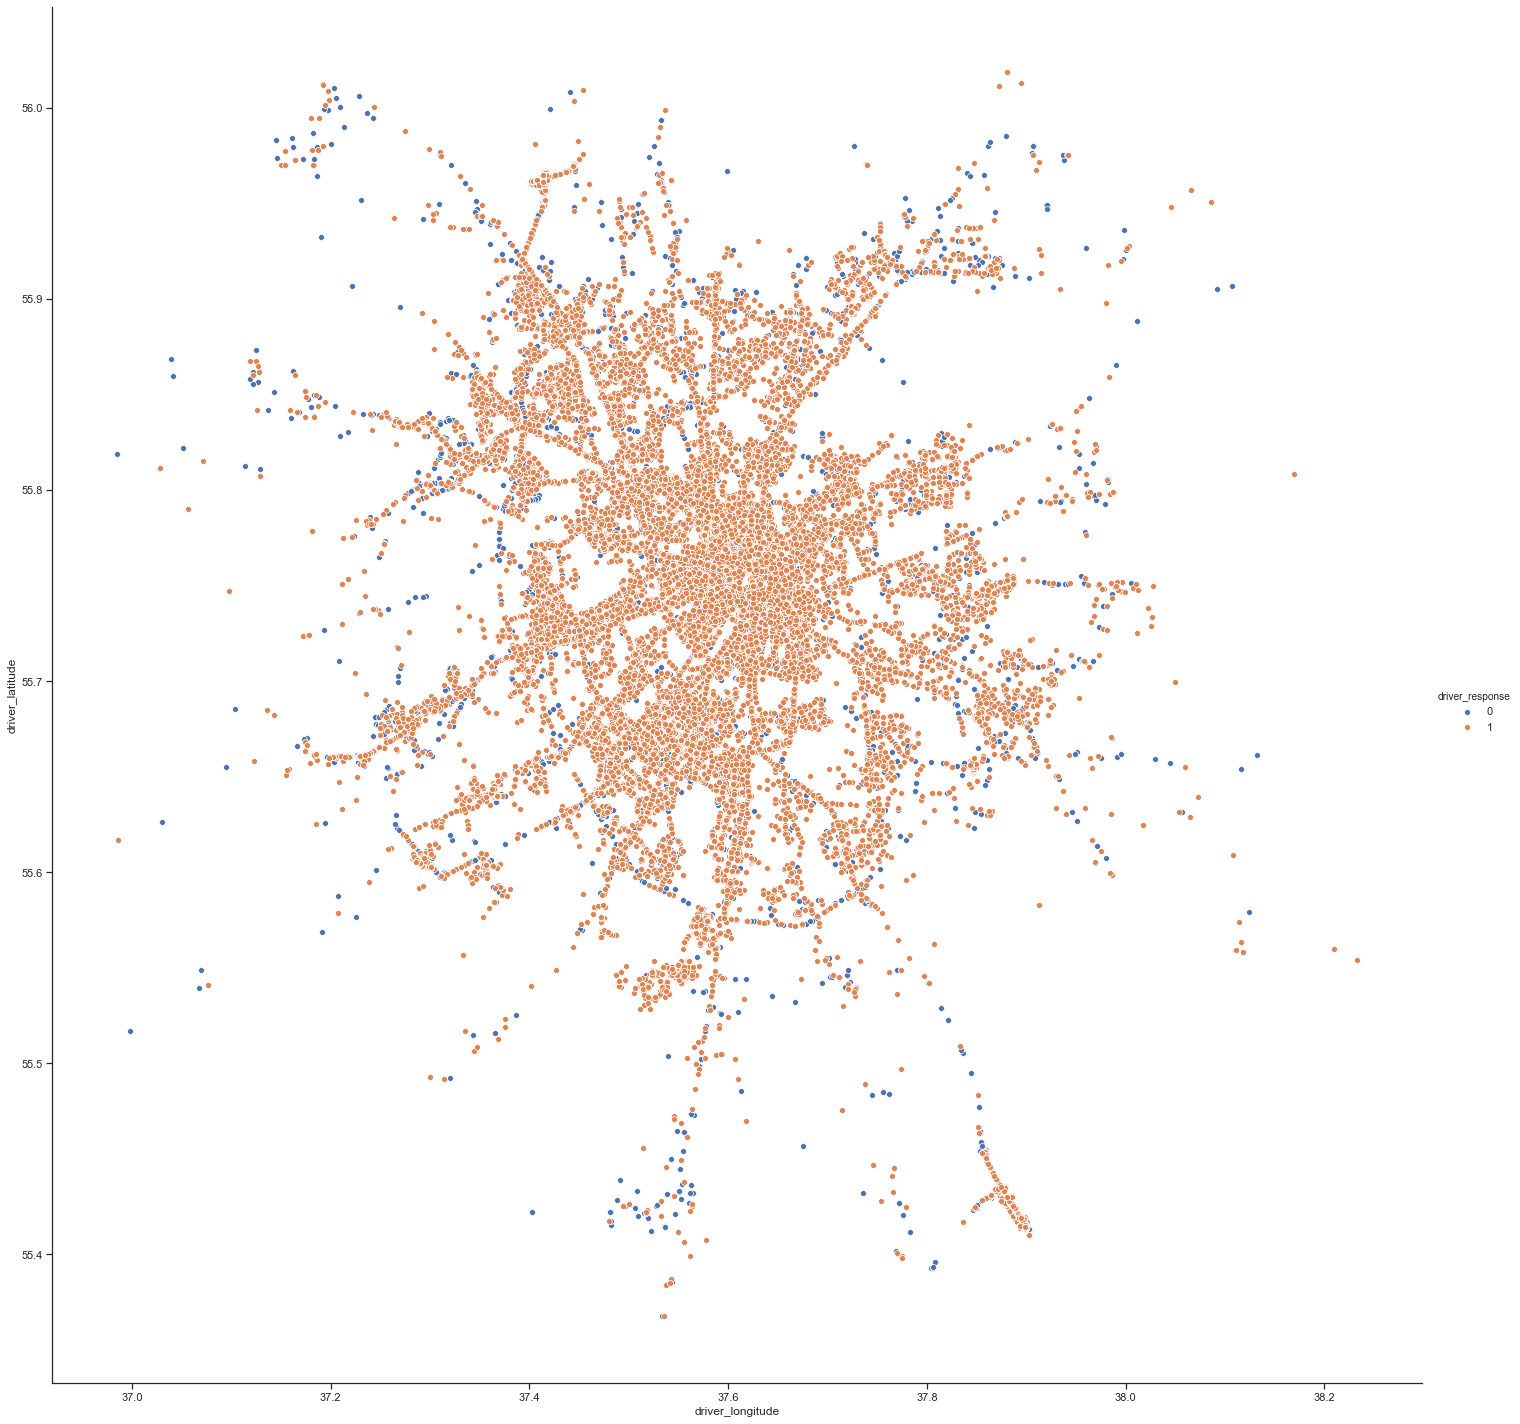

In [120]:
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(data = data,  x_vars=['driver_longitude'], y_vars=['driver_latitude'], hue='driver_response', height = 20)
plt.show()

# Москва! Звонят колокола!

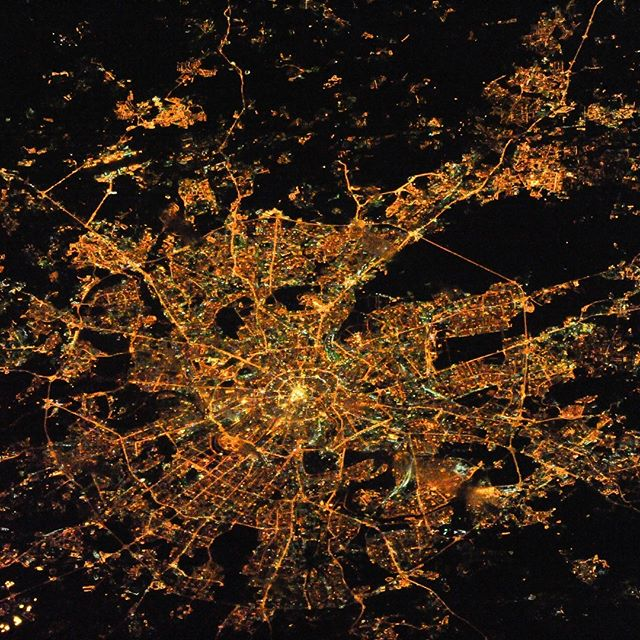

In [114]:
Image("8e4fNvcrm5A.jpg")

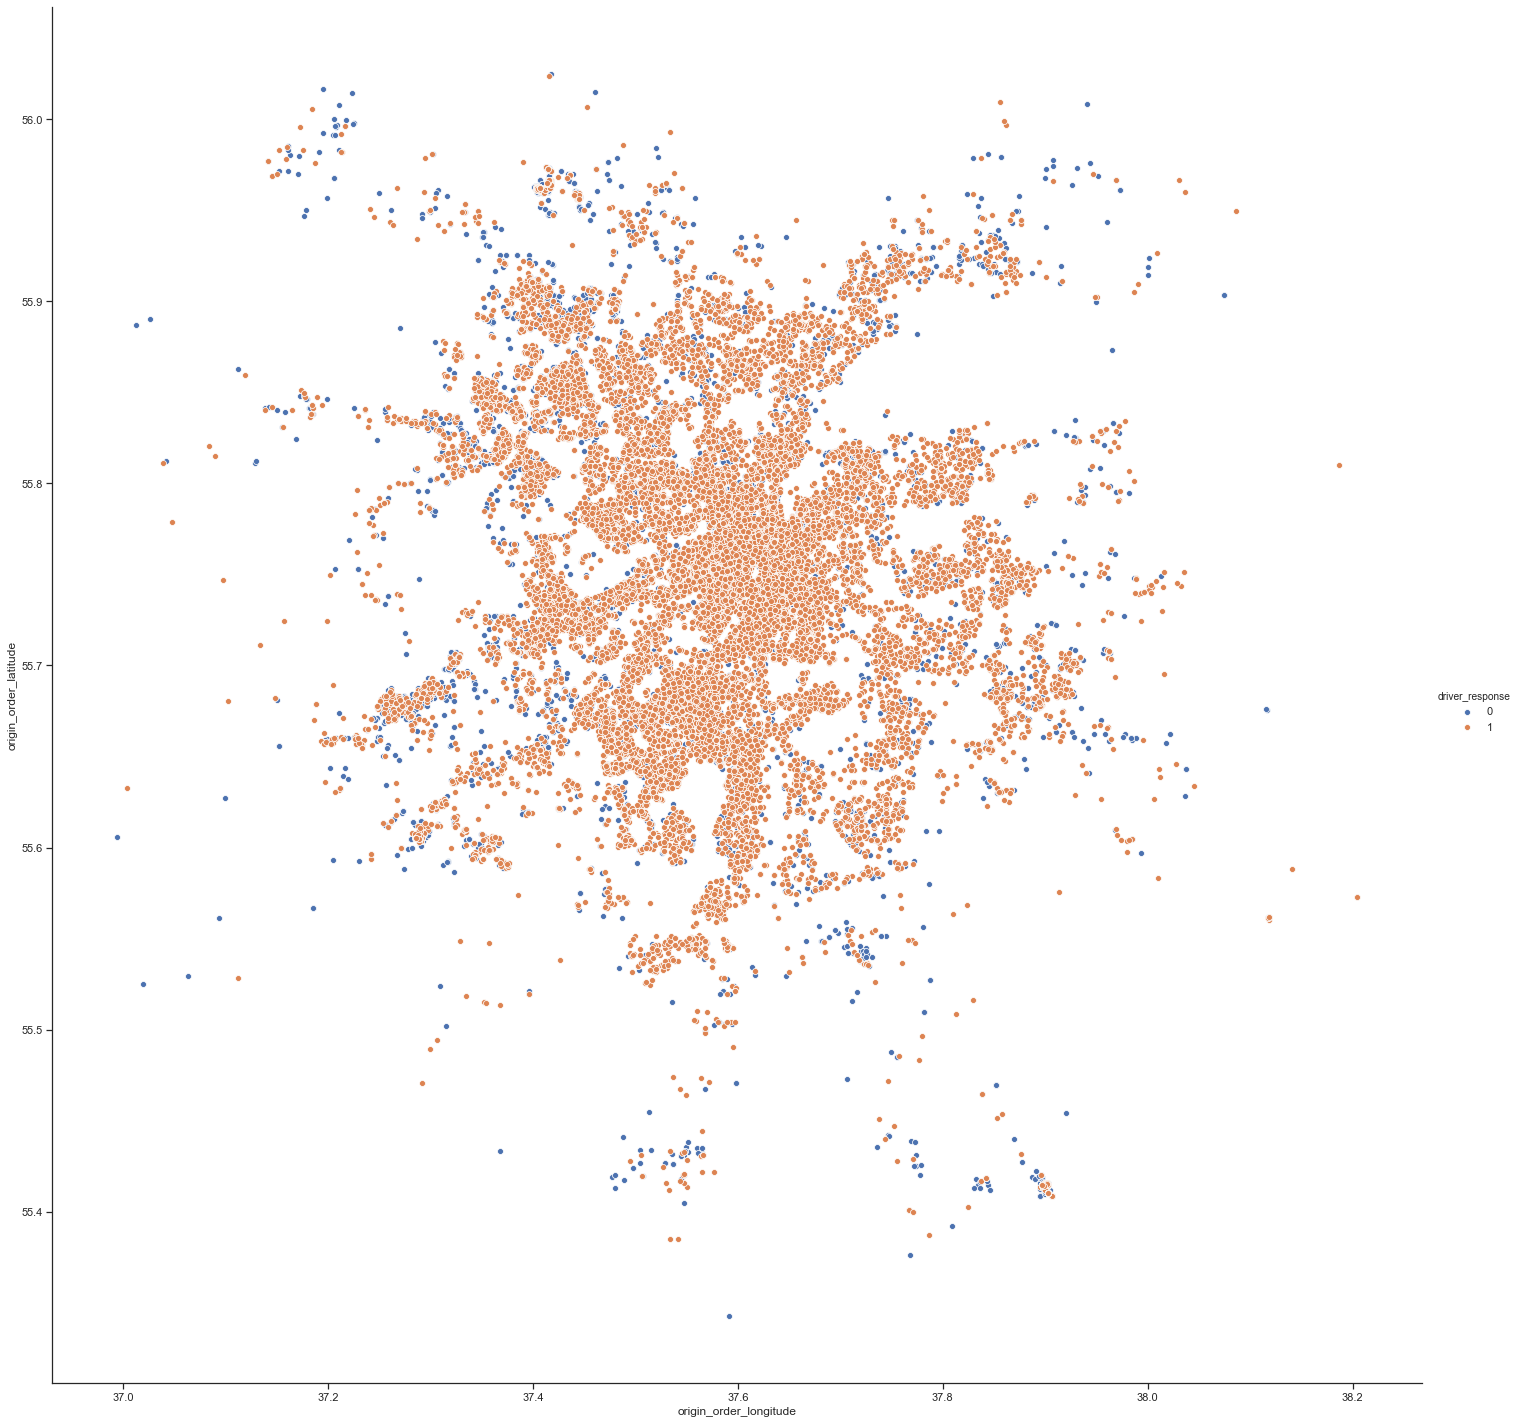

In [124]:
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(data = data,  x_vars=['origin_order_longitude'], y_vars=['origin_order_latitude'], hue='driver_response', height = 20)
plt.show()

Это Москва, бесспорно. Кстати, это можно было понять по координатам таксистов

Посчитаем корреляции между координатами

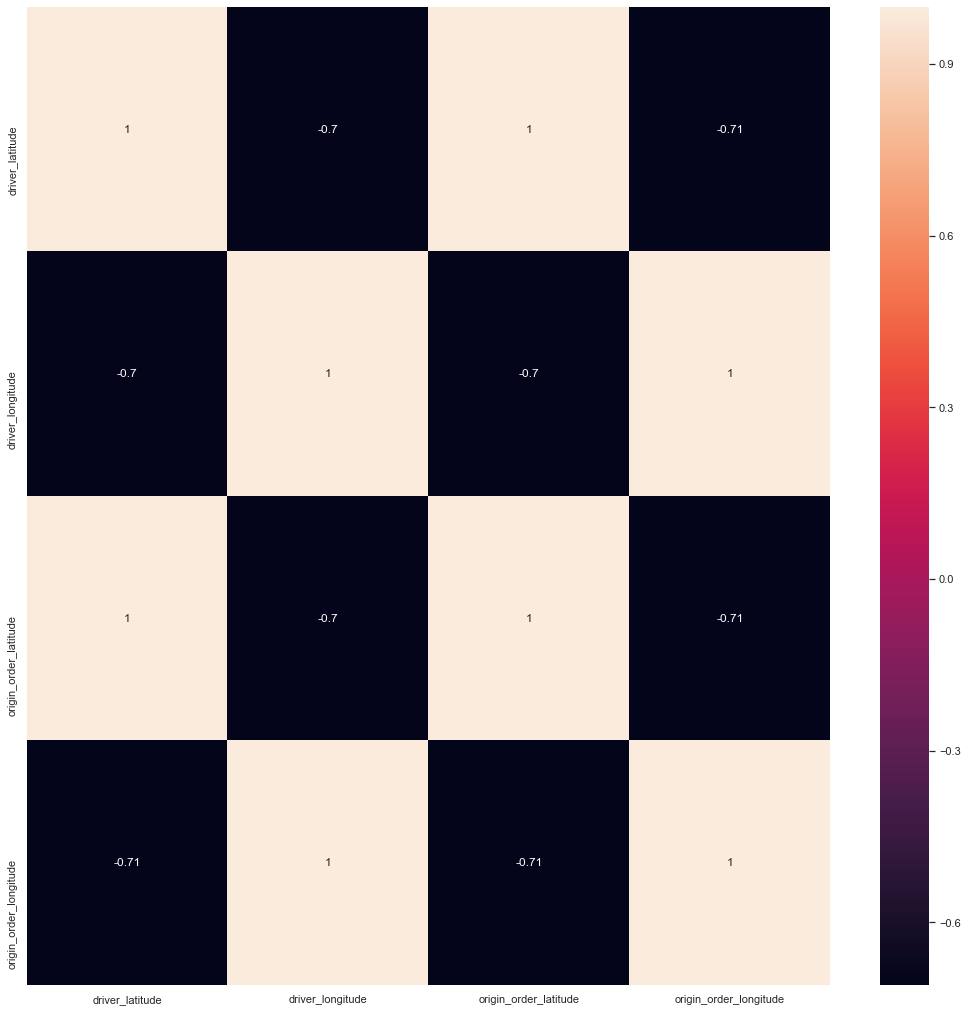

In [115]:
sns.set(rc={'figure.figsize':(18,18)})
correlation_matrix = data[['driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude']].corr(method ='pearson').round(2)
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

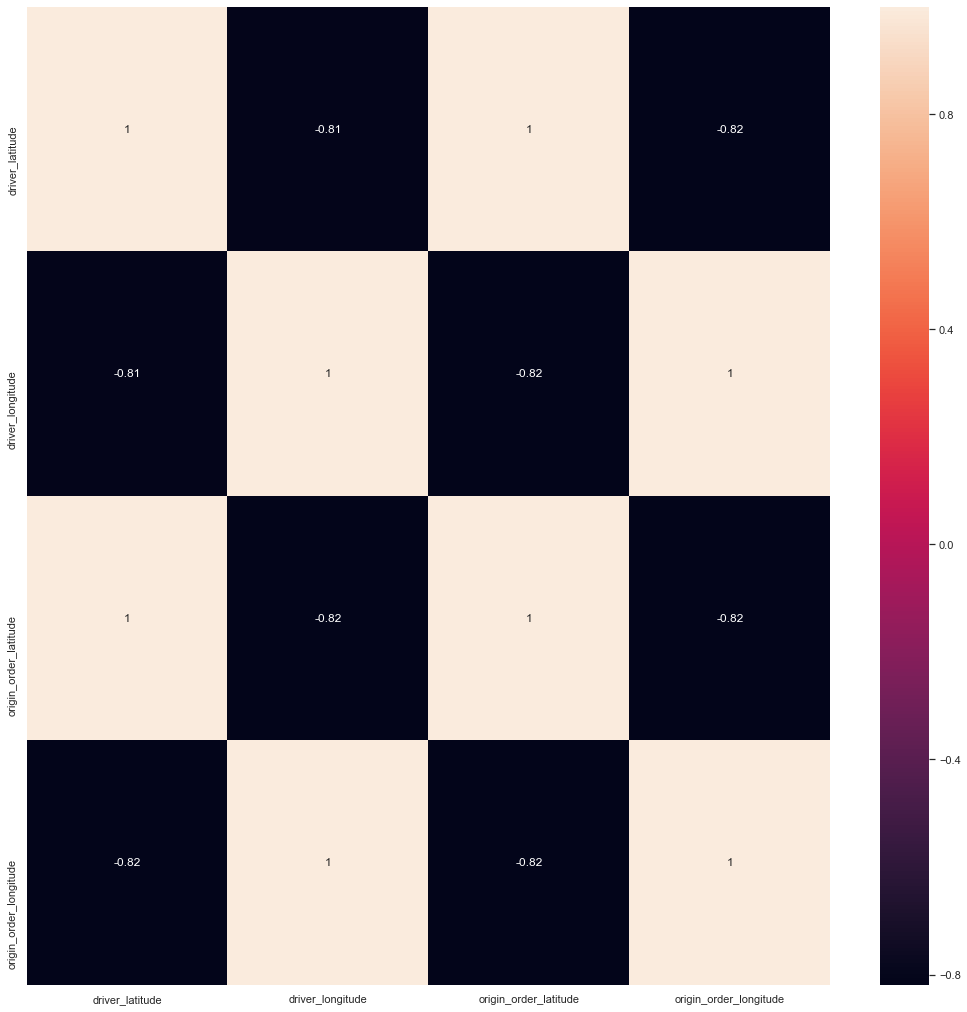

In [116]:
sns.set(rc={'figure.figsize':(18,18)})
correlation_matrix = data[data['driver_response'] == 0][['driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude']].corr(method ='pearson').round(2)
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

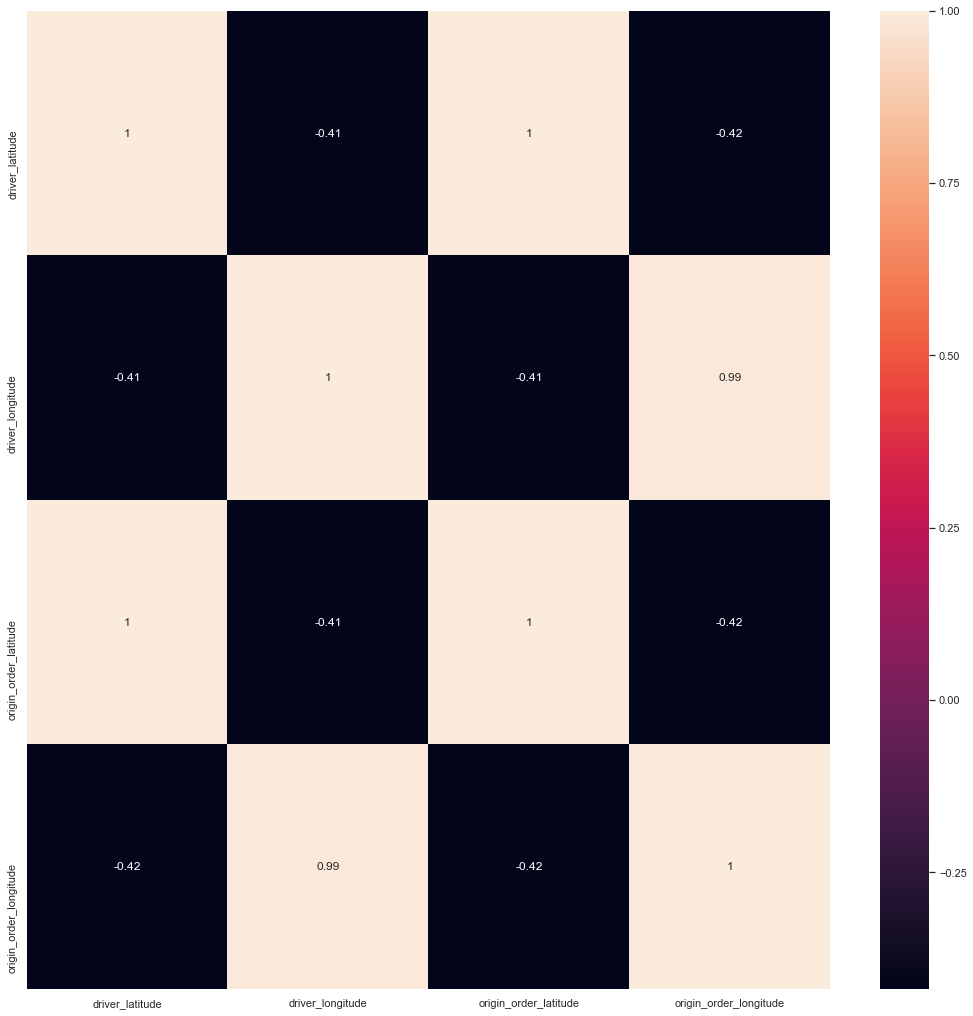

In [117]:
sns.set(rc={'figure.figsize':(18,18)})
correlation_matrix = data[data['driver_response'] == 1][['driver_latitude', 'driver_longitude', 'origin_order_latitude', 'origin_order_longitude']].corr(method ='pearson').round(2)
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

**Служба такси нормально работает, есть корреляция между заказчиком и таксистом**

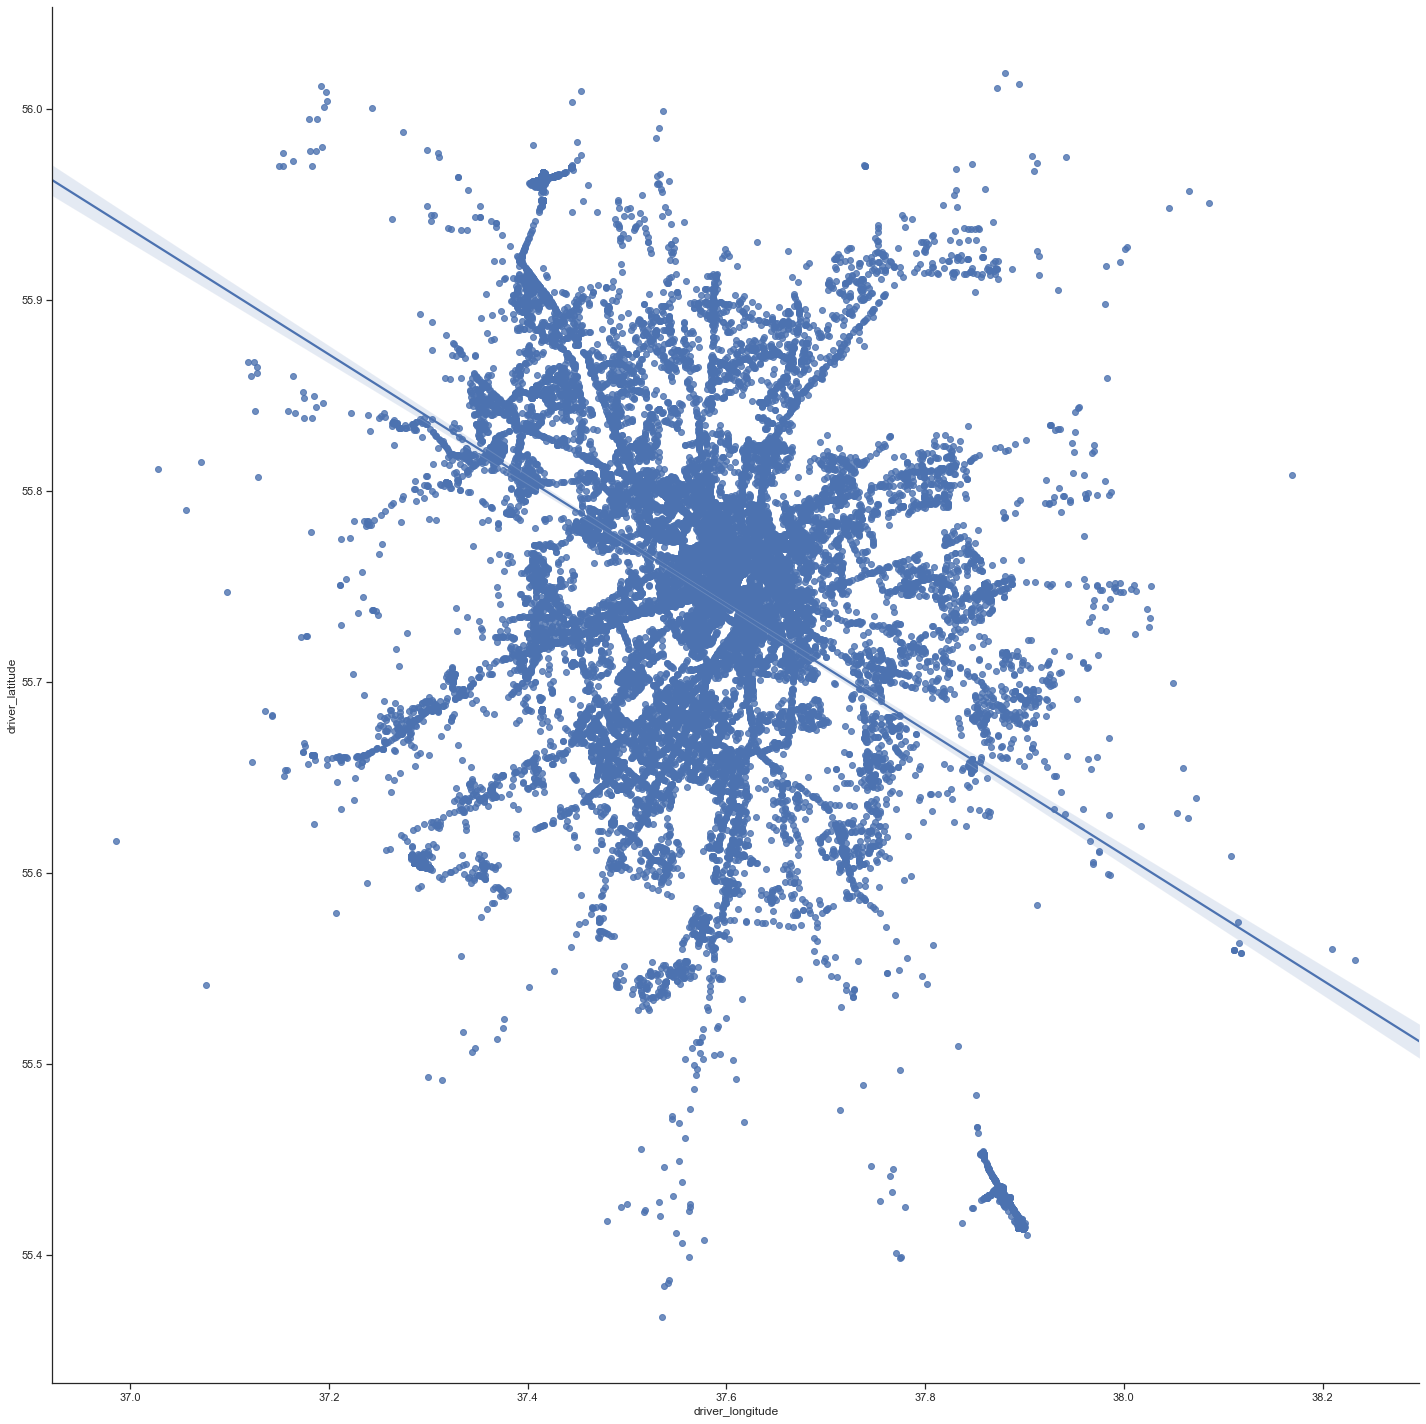

In [122]:
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(data = data[data['driver_response'] == 1],  x_vars=['driver_longitude'], y_vars=['driver_latitude'], kind = 'reg', height = 20)
plt.show()

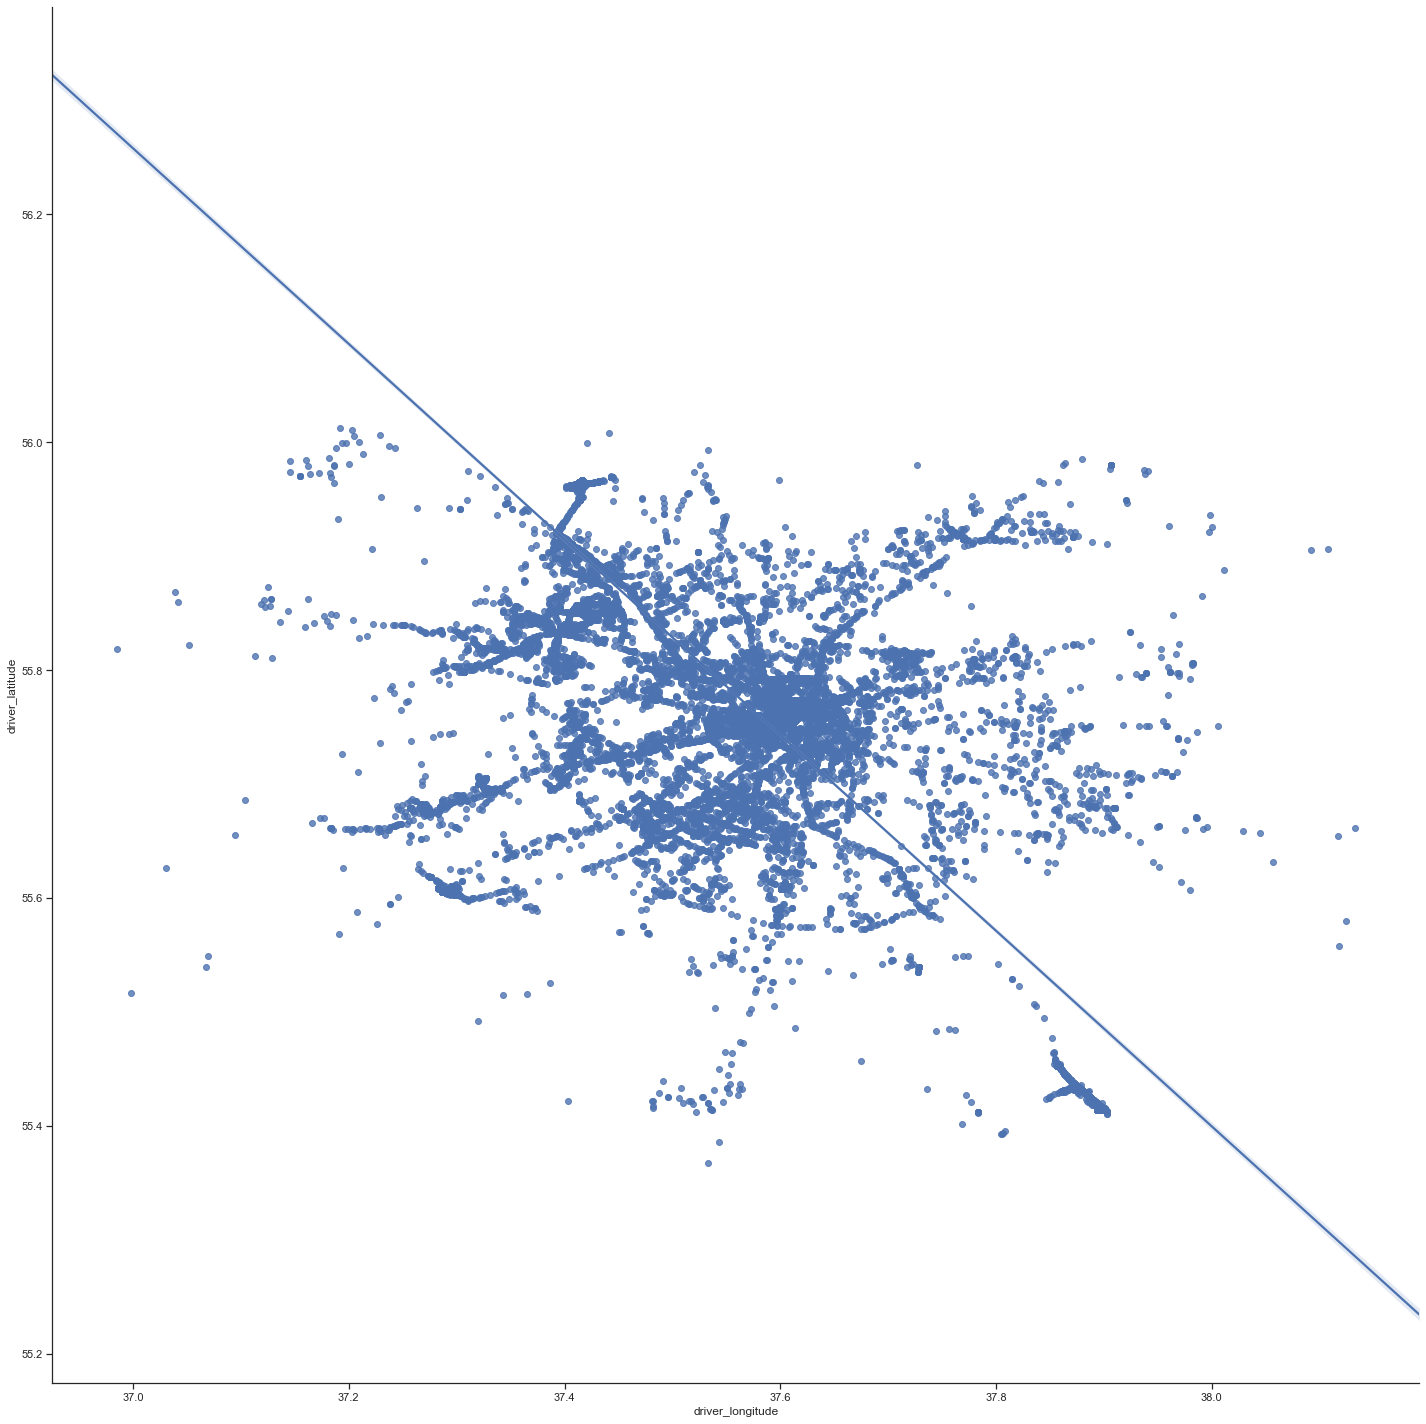

In [123]:
sns.set(style="ticks", color_codes=True)
fig = sns.pairplot(data = data[data['driver_response'] == 0],  x_vars=['driver_longitude'], y_vars=['driver_latitude'], kind = 'reg', height = 20)
plt.show()

Если все графики по координатам внимательно изучить, то можно сделать выводы:  
    - Есть три пятна концентрации таксистов: центр Москвы, Химки и Домодедово   
    - Когда таксисты далеко от этих точек они чаще отказывают  
    - Устойчивого понимания почему они это делают не первый взгляд нет   
    - Скорее всего мы не сможеи построить достойную модель на координатах, четких закономерностей нет   

**На этом моменте мне пришла в голову шутка, что смотреть надо не на местоположение водителей, а на самих водителей.  
Мягко говоря, кто-то знает город, а кому-то надо дорогу показать.
А потом подумал, а почему нет?**

In [46]:
data[['driver_gk','driver_response']].groupby('driver_gk').mean().sort_values(['driver_response'])

driver_response
driver_gk                 
5348              0.025723
1344              0.027523
1421              0.029861
5917              0.034435
4100              0.037534
1060              0.051799
2442              0.052300
462               0.054742
2236              0.057778
975               0.062167
6554              0.064706
1126              0.066151
3929              0.073801
1358              0.076222
2381              0.079108
1793              0.079325
6695              0.094527
5925              0.096386
4490              0.097534
4339              0.097744
6302              0.099307
3707              0.099819
5874              0.100719
1455              0.101124
2394              0.105263
1944              0.107042
6792              0.107542
6762              0.112259
5409              0.121429
5236              0.147436
...                    ...
6443              0.972414
3341              0.972603
3719              0.972892
4135              0.972973
2714              0.973856
5148              0.974026
4370              0.974843
4921              0.975000
2158              0.976852
259               0.979339
3162              0.979899
949               0.980000
6742              0.980769
2228              0.981132
2165              0.981132
2006              0.982609
3968              0.986047
4215              0.986486
4028              0.986486
5570              0.986667
2964              0.986842
3926              0.987421
5799              0.988235
896               0.990909
1857              0.990909
4516              1.000000
623               1.000000
1978              1.000000
5437              1.000000
3828              1.000000

[439 rows x 1 columns]

Очень четкая закономерность наблюдается, есть водители кoторые всегда везут, а есть которые очень редко. Может быть это и есть решение  
Проранжируем водителей по лояльности. Не будем из нумеровать, а просто присвоим им "коэффициент согласия" равный среднему значению целевой величины  
для данного водителя

Кстати, не уверен, что так можно делать, но очень хочется

In [190]:
data[['driver_gk','driver_response']].groupby('driver_gk').count().sort_values(['driver_response']).head()

driver_response
driver_gk                 
5955                    26
5909                    31
6405                    31
3833                    31
1316                    32

Здесь я проверил, что все водители совершали несколько поездок

In [191]:
data[['driver_gk','driver_response']].groupby('driver_gk').count().sort_values(['driver_response']).tail()

driver_response
driver_gk                 
2442                  1315
4490                  1409
1126                  1588
1060                  2211
1421                  2389

In [192]:
driver_mean = data[['driver_gk','driver_response']].groupby('driver_gk').mean().sort_values(['driver_response'])
driver_mean.head()

driver_response
driver_gk                 
5613              0.000000
5917              0.022917
1344              0.031250
5348              0.032864
1421              0.035998

In [193]:
i = data.loc[1,'driver_gk']
print(i)
driver_mean.loc[i,'driver_response']

6080


0.5566502463054187

Проверочка

In [84]:
for index in data.index:
    count = data.loc[index,'driver_gk']
    data.loc[index,'driver'] = driver_mean.loc[count,'driver_response']
data.head()

offer_gk  weekday_key  hour_key  driver_gk  order_gk  driver_latitude  \
1    759733            5        14       6080    358774        55.805342   
2    416977            6        14       6080    866260        55.813978   
4   1120055            4        16       6080    506710        55.803578   
5   1058203            6        15       6080    360328        55.818963   
7    128861            5        20       6080    254374        55.839318   

   driver_longitude  origin_order_latitude  origin_order_longitude  \
1         37.515023              55.819329               37.466398   
2         37.347688              55.814827               37.354074   
4         37.521602              55.812559               37.527407   
5         37.361033              55.814827               37.354074   
7         37.248862              55.839134               37.304101   

   distance_km  duration_min offer_class_group ride_type_desc  \
1       18.802        25.217          Standard        private   
2        6.747         9.800           Economy        private   
4       12.383        19.250           Economy        private   
5        6.747         9.800           Economy        private   
7        1.517         3.933           Economy        private   

   driver_response  distance_order    driver  
1                1           3.429  0.579137  
2                0           0.412  0.579137  
4                1           1.067  0.579137  
5                0           0.636  0.579137  
7                0           3.465  0.579137

Создали новый признак 'driver'

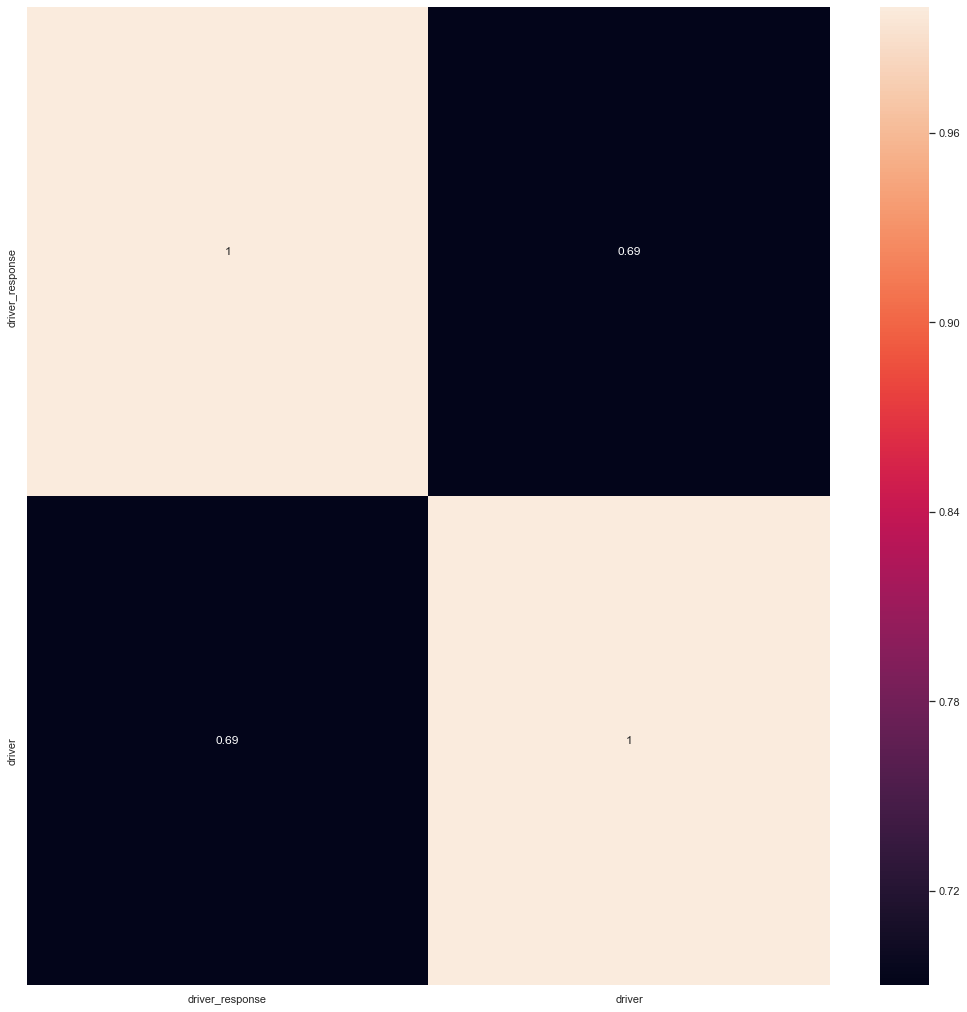

In [194]:
sns.set(rc={'figure.figsize':(18,18)})
correlation_matrix = data[['driver_response', 'driver']].corr(method ='pearson').round(2)
sns.heatmap(data=correlation_matrix, annot=True)
plt.show()

Есть корреляция, строим модели

In [195]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [196]:
X = data[['driver', 'driver_latitude']]
y = data['driver_response']

In [71]:
from sklearn.model_selection import train_test_split

In [197]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 27)

In [198]:
model = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [199]:
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      9691
           1       0.81      0.80      0.81      8750

    accuracy                           0.82     18441
   macro avg       0.82      0.82      0.82     18441
weighted avg       0.82      0.82      0.82     18441



In [200]:
X = data[['driver', 'driver_latitude','distance_km']]
y = data['driver_response']

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 27)

In [202]:
model = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [203]:
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      9691
           1       0.81      0.80      0.81      8750

    accuracy                           0.82     18441
   macro avg       0.82      0.82      0.82     18441
weighted avg       0.82      0.82      0.82     18441



Дольше просто смотрим какой признак весомее в модели и типы модели меняем (с логистической на "деревянную")

In [204]:
X = data[['driver']]
y = data['driver_response']

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 27)

In [206]:
model = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [207]:
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83      9691
           1       0.81      0.80      0.81      8750

    accuracy                           0.82     18441
   macro avg       0.82      0.82      0.82     18441
weighted avg       0.82      0.82      0.82     18441



In [208]:
from sklearn.ensemble import RandomForestClassifier

In [209]:
X = data[['driver', 'driver_latitude', 'distance_km']]
y = data['driver_response']

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 27)

In [211]:
model = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=3, random_state=0).fit(X_train, y_train)
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83      9691
           1       0.80      0.83      0.81      8750

    accuracy                           0.82     18441
   macro avg       0.82      0.82      0.82     18441
weighted avg       0.82      0.82      0.82     18441



**"Деревянная" модель отработала примеро так же как и логистичекая. Наш признак "driver" (коэффициент согласия водителя)  
оказался решающим**

**Но это еще не все. Помнится у нас неплохо время суток влияло на принятие решения. Создадим еще один признак.**

In [125]:
data[['hour_key','driver_response']].groupby('hour_key').describe()

driver_response                                              
                   count      mean       std  min  25%  50%   75%  max
hour_key                                                              
0                 4919.0  0.246188  0.430833  0.0  0.0  0.0  0.00  1.0
1                 2573.0  0.323747  0.467996  0.0  0.0  0.0  1.00  1.0
2                 1650.0  0.375758  0.484465  0.0  0.0  0.0  1.00  1.0
3                 1234.0  0.356564  0.479179  0.0  0.0  0.0  1.00  1.0
4                 1666.0  0.234694  0.423935  0.0  0.0  0.0  0.00  1.0
5                 1332.0  0.250000  0.433175  0.0  0.0  0.0  0.25  1.0
6                 1270.0  0.387402  0.487349  0.0  0.0  0.0  1.00  1.0
7                 1923.0  0.544462  0.498149  0.0  0.0  1.0  1.00  1.0
8                 2795.0  0.580322  0.493595  0.0  0.0  1.0  1.00  1.0
9                 2490.0  0.672289  0.469473  0.0  0.0  1.0  1.00  1.0
10                2062.0  0.716780  0.450672  0.0  0.0  1.0  1.00  1.0
11                2096.0  0.700859  0.457991  0.0  0.0  1.0  1.00  1.0
12                2270.0  0.689868  0.462649  0.0  0.0  1.0  1.00  1.0
13                2390.0  0.660669  0.473581  0.0  0.0  1.0  1.00  1.0
14                2530.0  0.646245  0.478229  0.0  0.0  1.0  1.00  1.0
15                3049.0  0.604133  0.489116  0.0  0.0  1.0  1.00  1.0
16                3268.0  0.570379  0.495098  0.0  0.0  1.0  1.00  1.0
17                3617.0  0.559580  0.496506  0.0  0.0  1.0  1.00  1.0
18                4312.0  0.512987  0.499889  0.0  0.0  1.0  1.00  1.0
19                4878.0  0.475605  0.499456  0.0  0.0  0.0  1.00  1.0
20                4983.0  0.467188  0.498972  0.0  0.0  0.0  1.00  1.0
21                5639.0  0.406810  0.491282  0.0  0.0  0.0  1.00  1.0
22                4850.0  0.382474  0.486042  0.0  0.0  0.0  1.00  1.0
23                5967.0  0.278197  0.448148  0.0  0.0  0.0  1.00  1.0

In [138]:
one = data[(data['hour_key'] >= 0) & (data['hour_key'] < 6)][['driver_response']].mean()
one

driver_response    0.286227
dtype: float64

In [139]:
four = data[(data['hour_key'] >= 6) & (data['hour_key'] < 12)][['driver_response']].mean()
four

driver_response    0.615859
dtype: float64

In [140]:
three = data[(data['hour_key'] >= 12) & (data['hour_key'] < 18)][['driver_response']].mean()
three

driver_response    0.613758
dtype: float64

In [141]:
two = data[(data['hour_key'] >= 18) & (data['hour_key'] <= 23)][['driver_response']].mean()
two

driver_response    0.413628
dtype: float64

In [212]:
data['time'] = 0.0
for index in data.index:
    hour = data.loc[index, 'hour_key']
    if (hour >= 0) & (hour < 6):
        data.loc[index, 'time'] = 0.286227
    elif (hour >= 18) & (hour <= 23):
        data.loc[index, 'time'] = 0.413628
    elif (hour >= 12) & (hour < 18):
        data.loc[index, 'time'] = 0.613758
    elif (hour >= 6) & (hour < 12):
        data.loc[index, 'time'] = 0.615859
data.head()    

offer_gk  weekday_key  hour_key  driver_gk  order_gk  driver_latitude  \
1    759733            5        14       6080    358774        55.805342   
2    416977            6        14       6080    866260        55.813978   
4   1120055            4        16       6080    506710        55.803578   
5   1058203            6        15       6080    360328        55.818963   
7    128861            5        20       6080    254374        55.839318   

   driver_longitude  origin_order_latitude  origin_order_longitude  \
1         37.515023              55.819329               37.466398   
2         37.347688              55.814827               37.354074   
4         37.521602              55.812559               37.527407   
5         37.361033              55.814827               37.354074   
7         37.248862              55.839134               37.304101   

   distance_km  duration_min offer_class_group ride_type_desc  \
1       18.802        25.217          Standard        private   
2        6.747         9.800           Economy        private   
4       12.383        19.250           Economy        private   
5        6.747         9.800           Economy        private   
7        1.517         3.933           Economy        private   

   driver_response  distance_order    driver      time  
1                1           3.429  0.579137  0.613758  
2                0           0.412  0.579137  0.613758  
4                1           1.067  0.579137  0.613758  
5                0           0.636  0.579137  0.613758  
7                0           3.465  0.579137  0.413628

In [213]:
X = data[['driver', 'time', 'distance_km']]
y = data['driver_response']

In [214]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 27)

In [215]:
model = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=3, random_state=0).fit(X_train, y_train)
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      9691
           1       0.82      0.80      0.81      8750

    accuracy                           0.82     18441
   macro avg       0.82      0.82      0.82     18441
weighted avg       0.82      0.82      0.82     18441



In [216]:
model = LogisticRegression(solver='liblinear').fit(X_train, y_train)
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83      9691
           1       0.80      0.81      0.81      8750

    accuracy                           0.82     18441
   macro avg       0.82      0.82      0.82     18441
weighted avg       0.82      0.82      0.82     18441



In [217]:
X = data[['time']]
y = data['driver_response']

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 27)

In [219]:
model = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=3, random_state=0).fit(X_train, y_train)
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.62      0.71      0.66      9691
           1       0.62      0.52      0.56      8750

    accuracy                           0.62     18441
   macro avg       0.62      0.61      0.61     18441
weighted avg       0.62      0.62      0.62     18441



In [220]:
X = data[['driver']]
y = data['driver_response']

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 27)

In [222]:
model = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=3, random_state=0).fit(X_train, y_train)
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83      9691
           1       0.81      0.80      0.81      8750

    accuracy                           0.82     18441
   macro avg       0.82      0.82      0.82     18441
weighted avg       0.82      0.82      0.82     18441



То же самое примерно. 'driver' решает.

# Теперь вспомним, что с признаком 'distance_km' мы удалили больше четверти данных (я удалил не мы, признаю)

**Проделаем все заново. Введем признаки 'driver' и 'time'. Но не будем удалять  'distance_km'**

In [223]:
data=pd.read_csv("taxi.csv") 
data.head(5)

offer_gk  weekday_key  hour_key  driver_gk  order_gk  driver_latitude  \
0   1105373            5        20       6080    174182        55.818842   
1    759733            5        14       6080    358774        55.805342   
2    416977            6        14       6080    866260        55.813978   
3    889660            2         6       6080    163522        55.745922   
4   1120055            4        16       6080    506710        55.803578   

   driver_longitude  origin_order_latitude  origin_order_longitude  \
0         37.334562              55.814567               37.355010   
1         37.515023              55.819329               37.466398   
2         37.347688              55.814827               37.354074   
3         37.421748              55.743469               37.431130   
4         37.521602              55.812559               37.527407   

   distance_km  duration_min offer_class_group ride_type_desc  driver_response  
0       -1.000        -1.000           Economy        private                0  
1       18.802        25.217          Standard        private                1  
2        6.747         9.800           Economy        private                0  
3       -1.000        -1.000           Economy        private                1  
4       12.383        19.250           Economy        private                1

In [225]:
for index in data.index:
    count = data.loc[index,'driver_gk']
    data.loc[index,'driver'] = driver_mean.loc[count,'driver_response']
data.head()

offer_gk  weekday_key  hour_key  driver_gk  order_gk  driver_latitude  \
0   1105373            5        20       6080    174182        55.818842   
1    759733            5        14       6080    358774        55.805342   
2    416977            6        14       6080    866260        55.813978   
3    889660            2         6       6080    163522        55.745922   
4   1120055            4        16       6080    506710        55.803578   

   driver_longitude  origin_order_latitude  origin_order_longitude  \
0         37.334562              55.814567               37.355010   
1         37.515023              55.819329               37.466398   
2         37.347688              55.814827               37.354074   
3         37.421748              55.743469               37.431130   
4         37.521602              55.812559               37.527407   

   distance_km  duration_min offer_class_group ride_type_desc  \
0       -1.000        -1.000           Economy        private   
1       18.802        25.217          Standard        private   
2        6.747         9.800           Economy        private   
3       -1.000        -1.000           Economy        private   
4       12.383        19.250           Economy        private   

   driver_response   driver  
0                0  0.55665  
1                1  0.55665  
2                0  0.55665  
3                1  0.55665  
4                1  0.55665

In [226]:
one = data[(data['hour_key'] >= 0) & (data['hour_key'] < 6)][['driver_response']].mean()
one

driver_response    0.315894
dtype: float64

In [227]:
four = data[(data['hour_key'] >= 6) & (data['hour_key'] < 12)][['driver_response']].mean()
four

driver_response    0.636893
dtype: float64

In [228]:
three = data[(data['hour_key'] >= 12) & (data['hour_key'] < 18)][['driver_response']].mean()
three

driver_response    0.636048
dtype: float64

In [229]:
two = data[(data['hour_key'] >= 18) & (data['hour_key'] <= 23)][['driver_response']].mean()
two

driver_response    0.428779
dtype: float64

In [233]:
data['time'] = 0.0
for index in data.index:
    hour = data.loc[index, 'hour_key']
    if (hour >= 0) & (hour < 6):
        data.loc[index, 'time'] = 0.315894
    elif (hour >= 18) & (hour <= 23):
        data.loc[index, 'time'] = 0.428779
    elif (hour >= 12) & (hour < 18):
        data.loc[index, 'time'] = 0.636048
    elif (hour >= 6) & (hour < 12):
        data.loc[index, 'time'] = 0.636893
data.head()  

offer_gk  weekday_key  hour_key  driver_gk  order_gk  driver_latitude  \
0   1105373            5        20       6080    174182        55.818842   
1    759733            5        14       6080    358774        55.805342   
2    416977            6        14       6080    866260        55.813978   
3    889660            2         6       6080    163522        55.745922   
4   1120055            4        16       6080    506710        55.803578   

   driver_longitude  origin_order_latitude  origin_order_longitude  \
0         37.334562              55.814567               37.355010   
1         37.515023              55.819329               37.466398   
2         37.347688              55.814827               37.354074   
3         37.421748              55.743469               37.431130   
4         37.521602              55.812559               37.527407   

   distance_km  duration_min offer_class_group ride_type_desc  \
0       -1.000        -1.000           Economy        private   
1       18.802        25.217          Standard        private   
2        6.747         9.800           Economy        private   
3       -1.000        -1.000           Economy        private   
4       12.383        19.250           Economy        private   

   driver_response   driver      time  
0                0  0.55665  0.428779  
1                1  0.55665  0.636048  
2                0  0.55665  0.636048  
3                1  0.55665  0.636893  
4                1  0.55665  0.636048

Кстати, забыл показать, что знаю, что такое профайл.

In [242]:
import pandas_profiling
data.profile_report()

В общем, ничего нового, данные грязные, но нас это не волнует, у нас есть 'driver' и 'time'

In [234]:
X = data[['driver', 'time']]
y = data['driver_response']

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 27)

In [237]:
model = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=3, random_state=0).fit(X_train, y_train)
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     12651
           1       0.81      0.82      0.81     12349

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



In [236]:
model = LogisticRegression(solver='liblinear').fit(X_train, y_train)
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     12651
           1       0.81      0.81      0.81     12349

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



In [238]:
X = data[['driver']]
y = data['driver_response']

In [239]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 27)

In [240]:
model = RandomForestClassifier(criterion='gini', n_estimators=100, max_depth=3, random_state=0).fit(X_train, y_train)
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.82      0.80      0.81     12651
           1       0.80      0.83      0.81     12349

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



In [241]:
model = LogisticRegression(solver='liblinear').fit(X_train, y_train)
model_pred = model.predict(X_test)
print(classification_report(y_test, model_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     12651
           1       0.81      0.81      0.81     12349

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



Тот же результат по большому счету

# Вывод.

Не уверен, что получена модель с хорошими предсказательными характеристиками, но управляющеьу бизнесом такси  
можно дать следующий совет.
  
**"Кадры решают все"  
           И.Сталин.**
             
Хотите больше заказов, работайте с кадрами, воспитывайте, мотивируйте и не ведитесь на отмазы, типа далеко, рано, поздно и проч.